# Create a model on the protein data

## Data source

Data are located under the directory `raw` and taken from the following paper:
<ul>
<b>Deciphering the determinants of recombinant protein yield across the human secretome</b>
Helen O. Masson, Chih-Chung Kuo, Magdalena Malm, Magnus Lundqvist, Åsa Sievertsson, Anna Berling, Hanna Tegel, Sophia Hober,  Mathias Uhlén, Luigi Grassi, Diane Hatton, Johan Rockberg, Nathan E. Lewis

doi: https://doi.org/10.1101/2022.12.12.520152
</ul>

Data are from the paper's [supplemental section](https://www.biorxiv.org/content/10.1101/2022.12.12.520152v1.supplementary-material)

More specifically, two files are analyzed from `raw` which are sourced from:
 - `raw/media-4.xlsx` -> [Supplementary Data 2](https://www.biorxiv.org/content/biorxiv/early/2022/12/14/2022.12.12.520152/DC4/embed/media-4.xlsx?download=true)
 - `raw/media-12.xlsx` -> [Supplementary Data 10](https://www.biorxiv.org/content/biorxiv/early/2022/12/14/2022.12.12.520152/DC12/embed/media-12.xlsx?download=true)

## Notes

If you have problems with `openpyxl` when loading the xlsx file, try changing to kernel `Python(jupter)`, or else create a conda environment with all the pip install'd packages below and try running the notebook server from the new environment.

### Import Libraries and Define Functions

In [ ]:
!pip install xgboost==1.5.1 numpy==1.25.0 shap==0.46.0 catboost==1.2.5 graphviz==0.20.3 interpret==0.6.2 openpyxl==3.1.5 optuna==3.6.1 optuna-integration==3.6.0 scikit-learn==1.5.1 seaborn==0.13.2 xlrd==2.0.1 missingno

In [ ]:
!pip show shap scikit-learn openpyxl xlrd seaborn interpret optuna graphviz catboost optuna-integration

In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import shap

from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# ML
import optuna
from optuna.integration import CatBoostPruningCallback
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
import catboost as cb
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Functions

def show_heatmap(df, predictor_list, target = 'Status', figsize = (20,10), title='Correlation Heatmap'):
    # create a correlation matrix but specify numeric_only=True to only include columns with numeric data
    correlation_matrix = df[predictor_list + [target]].corr(method='pearson', min_periods=1)
    # create a mask for the upper triangle
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    # set up the matplotlib figure
    plt.figure(figsize=figsize)
    # add a title
    plt.title(title)
    # plot the heatmap
    sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', center=0, linewidths=0.5)
    plt.show()

def standardize_values(X):
    from sklearn.preprocessing import StandardScaler
    # create a standard scaler object
    scaler = StandardScaler()
    # fit the scaler to the data
    scaler.fit(X)
    # transform the data
    X_stand = scaler.transform(X)
    return X_stand

def t_sne_plot(X, y, title='t-SNE plot'):
    import matplotlib.pyplot as plt
    from sklearn.manifold import TSNE
    # create a t-SNE object
    tsne = TSNE(n_components=2, random_state=0)
    # fit the t-SNE object to the data
    X_tsne = tsne.fit_transform(X)
    # create a scatter plot of the t-SNE data
    plt.figure(figsize=(10,10))
    plt.scatter(X_tsne[y==0, 0], X_tsne[y==0, 1], label='Fail', c='red', alpha=0.5)
    plt.scatter(X_tsne[y==1, 0], X_tsne[y==1, 1], label='Pass', c='blue', alpha=0.5)
    plt.title(title)
    plt.legend()
    plt.show()

def new_evaluate(model, X, y):
    proba_preds = model.predict_proba(X)[:,1]
    preds = model.predict(X)
    pred_labels = np.rint(preds)

    import sklearn.metrics as metrics
    # calculate the fpr and tpr for all thresholds of the classification
    fpr, tpr, threshold = metrics.roc_curve(y, proba_preds)
    # calculate AUC
    roc_auc = metrics.auc(fpr, tpr)
    # calculate accuracy
    accuracy = metrics.accuracy_score(y, pred_labels)

    print(f"AUC={roc_auc:.3f}")
    print(f"Accuracy={accuracy:.3f}")
          
    #plot a confusion matrix
    cm = metrics.confusion_matrix(y, pred_labels)

    # plot a confusion matrix as a heatmap
    import matplotlib.pyplot as plt
    import seaborn as sns
    # label axes as "predicted and "actual"
    ax = sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')#, center=0, linewidths=0.5)
    ax.set(xlabel='Predicted', ylabel='Actual')
    plt.show()

    # print the classification report
    print(metrics.classification_report(y, pred_labels))

    # plot the ROC curve
    # label axes
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    #add grid
    plt.grid(True)
    # plot the ROC curve
    plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
    # plot the 45 degree line
    plt.plot([0,1], [0,1], 'k--', label="Random")
    # add a legend
    plt.legend()
    # show the plot
    #plt.show()


### Load data

In [3]:
# read in the sheet called 'all features' from the raw/media-4.xlsx excel file

df = pd.read_excel('data/media-4.xlsx', sheet_name='all features')
target_df = pd.read_excel('data/media-12.xlsx')

# drop unnecessary columns
df = df.drop(columns=['sample_ID','uniprot_id'])
target_df = target_df[['Gene.name', 'Status']]

# Rename column in the target for merging
target_df = target_df.rename(columns={'Gene.name':'human_symbol'})

# Set Index
df.set_index('human_symbol', inplace=True)
target_df.set_index('human_symbol', inplace=True)

# Group by index and calculate the mean for each group (this will erase duplicate genes)
df = df.groupby(df.index).mean()

### Pre-processing

<Axes: >

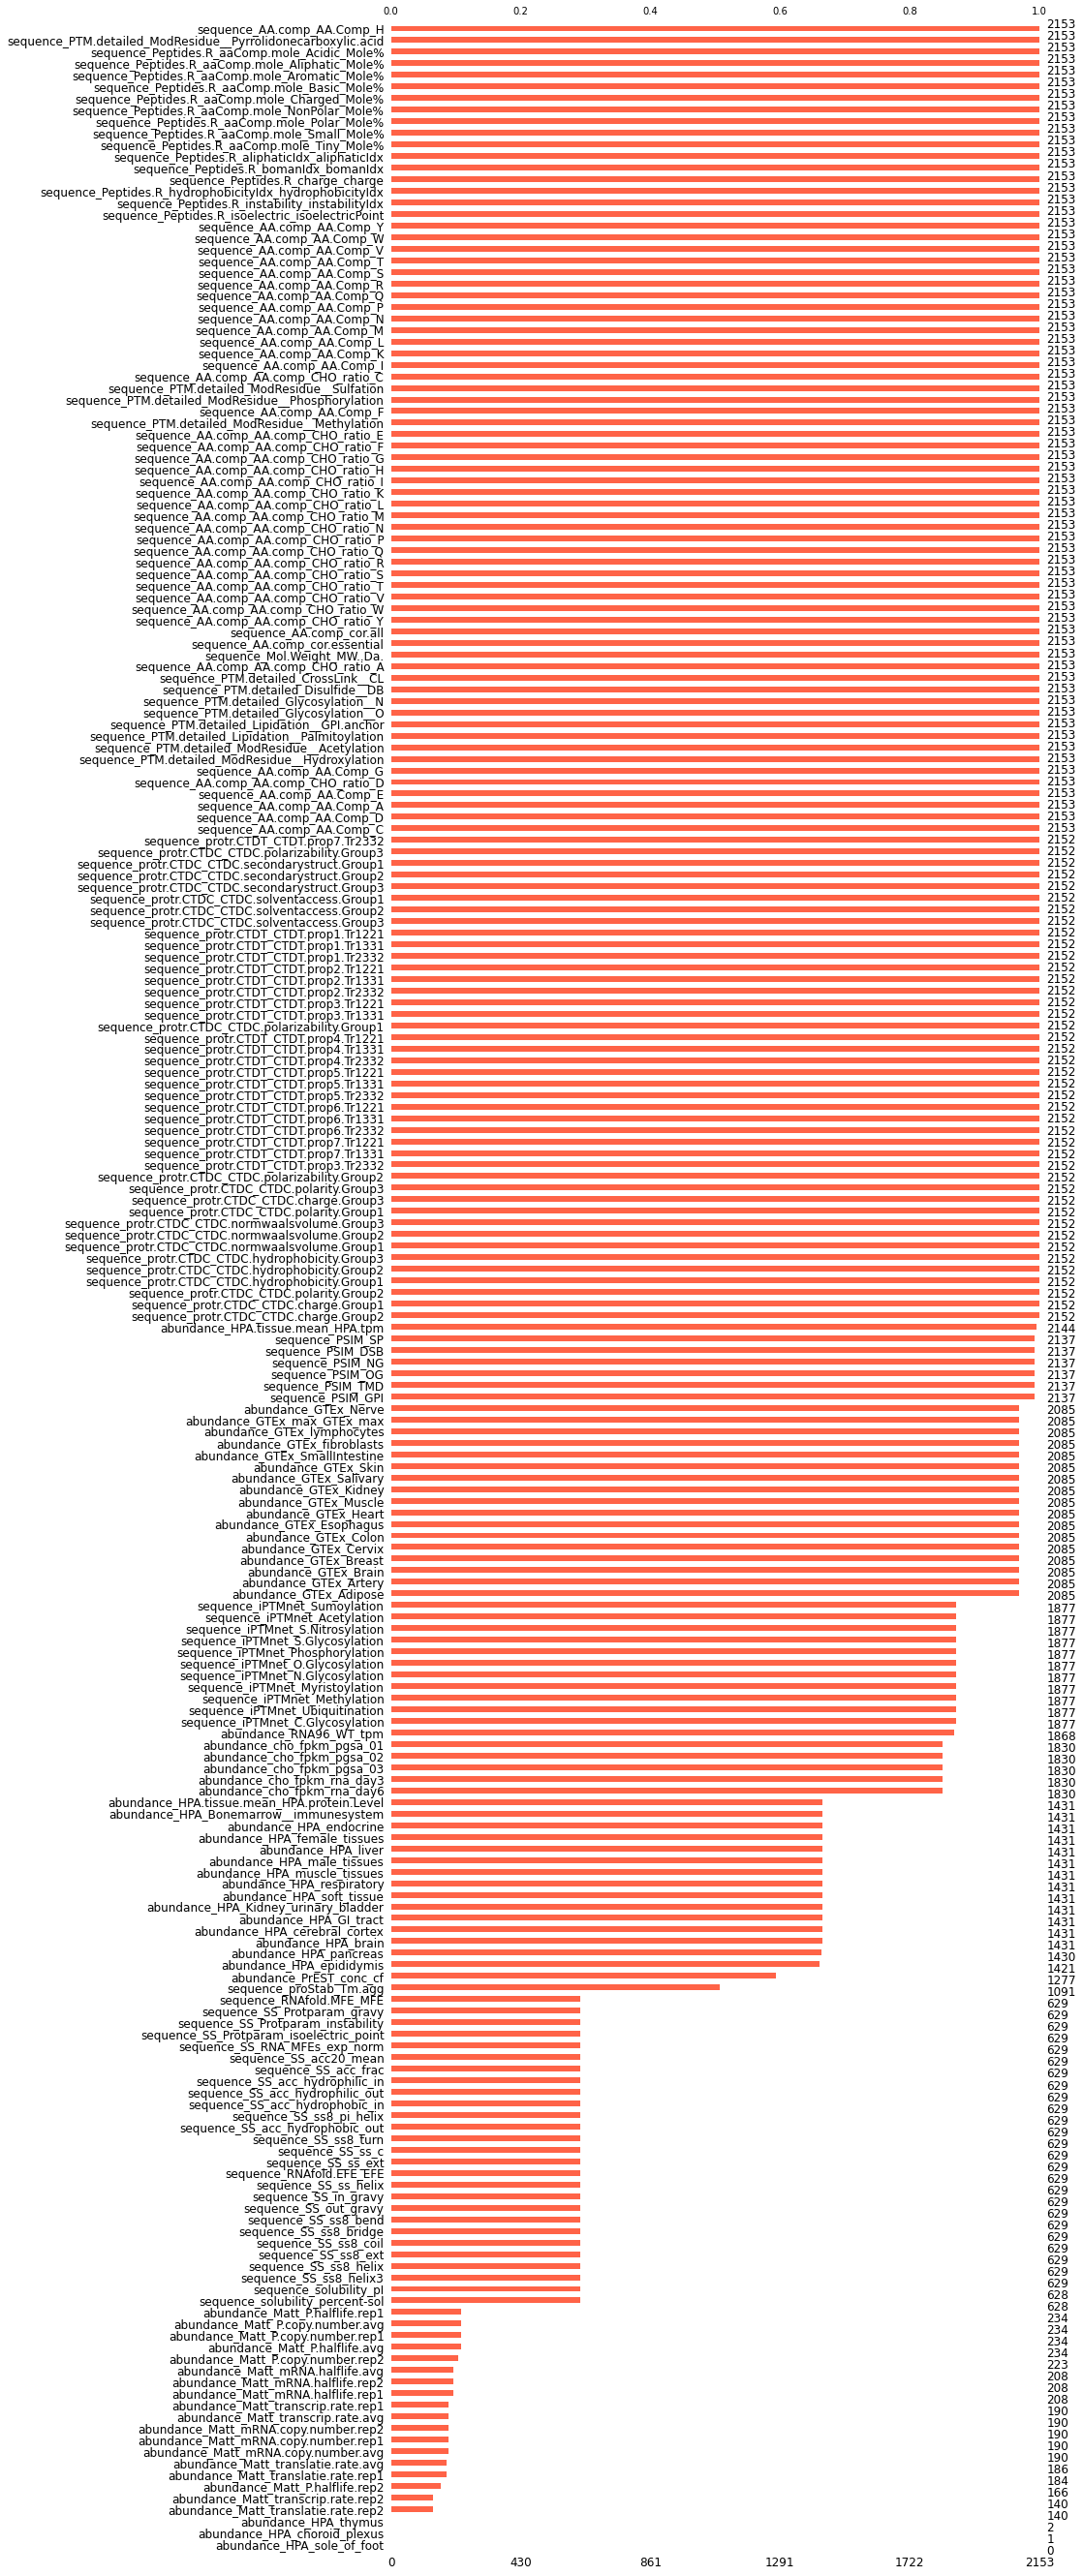

In [4]:
# Missing values
msno.bar(df,figsize=(12, 48), sort="ascending",fontsize=12, color='tomato')

In [5]:
# Drop columns with more than 50% of missing values

# Define the threshold
threshold = 0.5

# Calculate the percentage of missing values for each column
missing_percentage = df.isnull().mean()

# Drop columns exceeding the threshold
columns_to_drop = missing_percentage[missing_percentage > threshold].index
df_dropped = df.drop(columns=columns_to_drop)

In [6]:
# Use KNN inputer to inpute the rest of the missing values

# Save the original index
original_index = df_dropped.index

imputer = KNNImputer(n_neighbors=5)
df_imputed_array = imputer.fit_transform(df_dropped)

df_imputed = pd.DataFrame(df_imputed_array, columns=df_dropped.columns, index=original_index)

In [7]:
# Replace 'Pass' with 1 and anything else with 0 in the target_df

target_df.loc[:,'Status'] = target_df['Status'].replace({'Pass':1})
# if 'Status' != 1, replace with 0
target_df.loc[(target_df['Status']!=1),'Status'] = 0
# display unique classes in 'Status' column
display(target_df['Status'].groupby(target_df['Status']).count())
target_df.head()

Status
0     895
1    1270
Name: Status, dtype: int64

Status
human_symbol       
A1BG              1
A2M               1
A2ML1             0
AADACL2           0
ABHD15            0

In [8]:
# subsample tartet_df['Status'] == 1 to 895
pass_df = target_df[target_df['Status'] == 1].sample(n=895, random_state=1)
fail_df = target_df[target_df['Status'] == 0]

# combine pass_df and fail_df
new_target_df = pd.concat([pass_df, fail_df])

print(new_target_df['Status'].groupby(new_target_df['Status']).count())
new_target_df.head()

Status
0    895
1    895
Name: Status, dtype: int64


Status
human_symbol       
PRL               1
CD55              1
IFNA7             1
DEFB116           1
RBP3              1

In [9]:
# Combine features df with Targets df

df_merged = df_imputed.join(new_target_df, how='inner')
print(df_merged.shape)

(1760, 171)


### Explore balance and variability 

In [10]:
# find any columns with zero variability
zero_var_cols = df_merged.columns[df_merged.nunique() == 1]
print(zero_var_cols)

Index([], dtype='object')


Dropping highly correlated columns can be a useful step in a machine learning pipeline to reduce multicollinearity and simplify the model, especially if you're using algorithms that assume feature independence or can be sensitive to multicollinearity, such as linear regression or logistic regression.

In [11]:
# Define correlation threshold
correlation_threshold = 0.80

# Create correlation matrix (numeric_only=True to only include numeric data)
correlation_matrix = df_merged.corr(method='pearson')

# Select upper triangle of correlation matrix
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find index of feature columns with correlation greater than correlation_threshold
to_drop = [column for column in upper.columns if any(abs(upper[column]) > correlation_threshold)]

# Print columns to drop and their highly correlated counterparts
for column in to_drop:
    print(f"Column {column} is highly correlated with {list(upper.index[upper[column] > correlation_threshold])}")

print()
print(f'{len(to_drop)} columns to drop: {to_drop}')

Column abundance_GTEx_Breast is highly correlated with ['abundance_GTEx_Adipose']
Column abundance_GTEx_max_GTEx_max is highly correlated with ['abundance_GTEx_Salivary']
Column abundance_HPA.tissue.mean_HPA.protein.Level is highly correlated with ['abundance_HPA_Kidney_urinary_bladder', 'abundance_HPA_endocrine', 'abundance_HPA_liver', 'abundance_HPA_respiratory']
Column abundance_cho_fpkm_pgsa_01 is highly correlated with ['abundance_RNA96_WT_tpm']
Column abundance_cho_fpkm_pgsa_02 is highly correlated with ['abundance_RNA96_WT_tpm', 'abundance_cho_fpkm_pgsa_01']
Column abundance_cho_fpkm_pgsa_03 is highly correlated with ['abundance_RNA96_WT_tpm', 'abundance_cho_fpkm_pgsa_01', 'abundance_cho_fpkm_pgsa_02']
Column sequence_AA.comp_AA.comp_CHO_ratio_A is highly correlated with ['sequence_AA.comp_AA.Comp_A']
Column sequence_AA.comp_AA.comp_CHO_ratio_C is highly correlated with ['sequence_AA.comp_AA.Comp_C']
Column sequence_AA.comp_AA.comp_CHO_ratio_D is highly correlated with ['sequenc

Next we create a list of predictor columns (features) that will be used in a machine learning model, while excluding certain columns that are not useful as predictors or have been identified to be removed due to high correlation.

In [12]:
predictor_list = list(df_merged.columns)
predictor_list.remove('Status')

#remove the columns to drop
predictor_list = [x for x in predictor_list if x not in to_drop]
print(len(predictor_list))

117


Nothing Appears to be strongly correlated with the target (Status) **See the bottom of the plot**

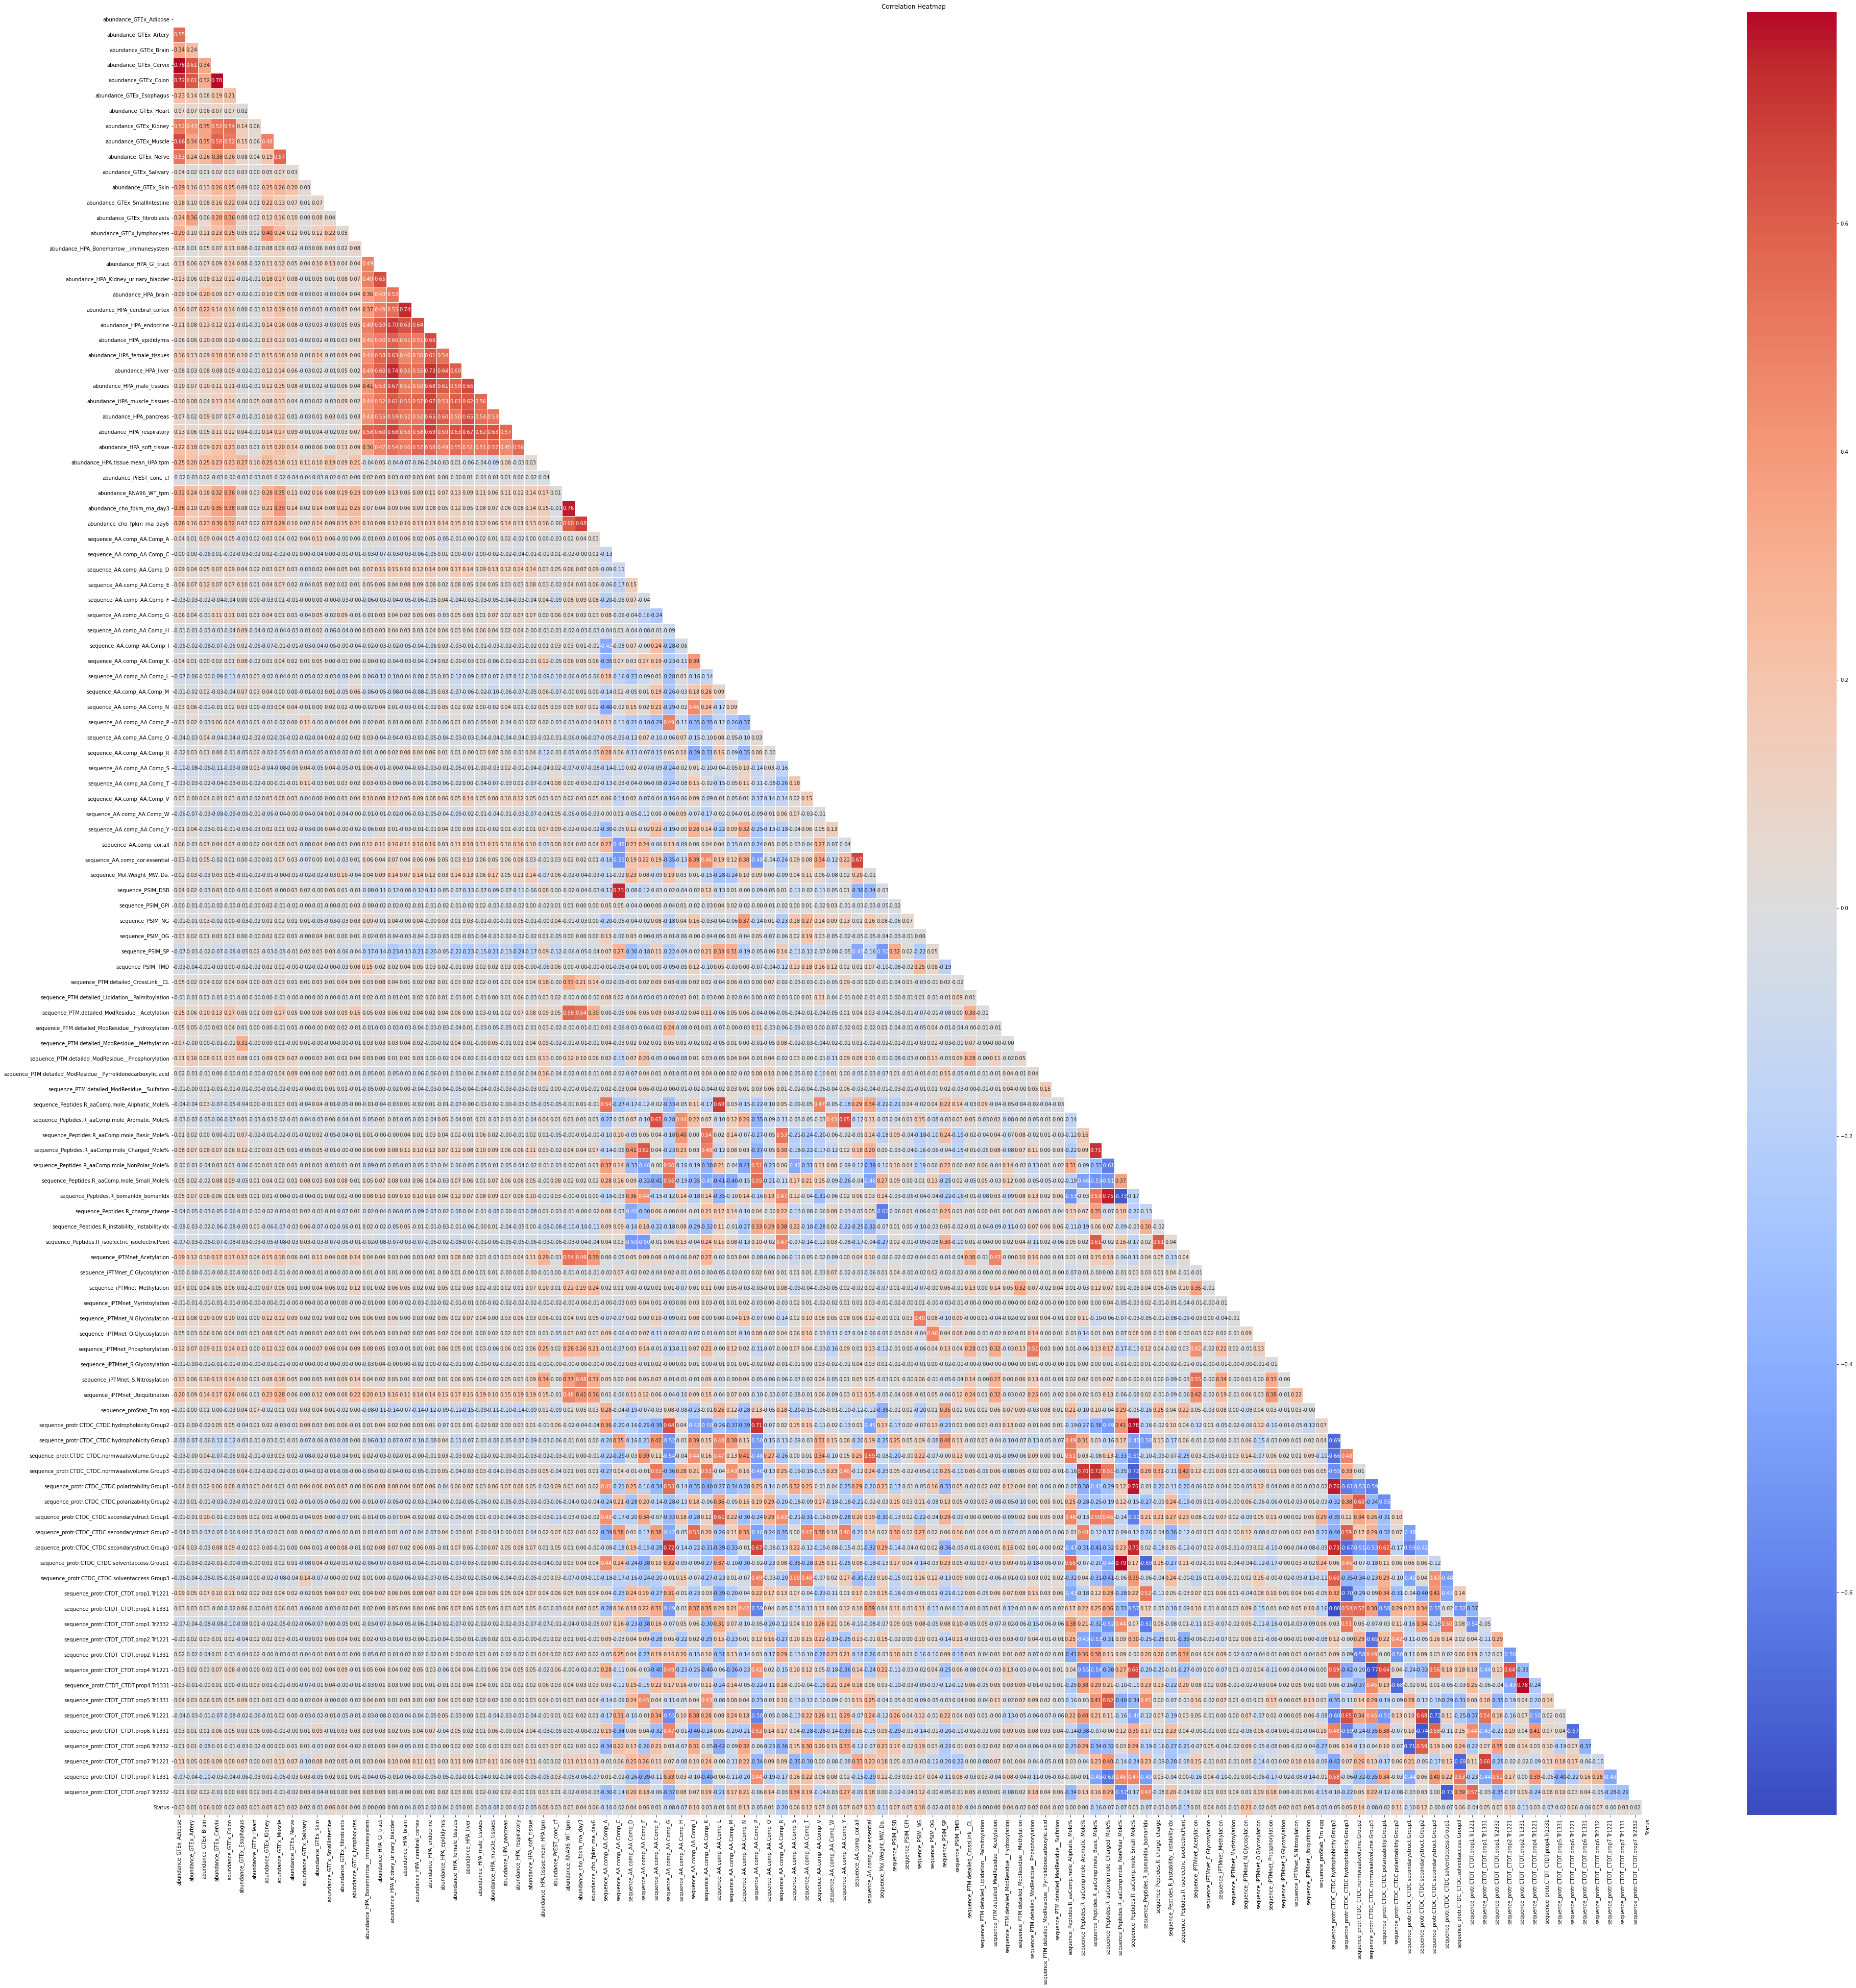

In [13]:
show_heatmap(df=df_merged, target='Status', predictor_list=predictor_list, title='Correlation Heatmap', figsize=(65,65))

### Explore effect of standardization

Seems to have no effect on correlation, good

In [14]:
X_stand  = standardize_values(df_merged[predictor_list].values)

# convert X_stand to a dataframe with columns = df.columns
X_stand_df = pd.DataFrame(X_stand, columns=predictor_list)
# set index of X_stand_df to be the same as new_df
X_stand_df.index = df_merged.index
# add 'Status' to X_stand_df
X_stand_df['Status'] = df_merged['Status']
X_stand_df.describe()

abundance_GTEx_Adipose  abundance_GTEx_Artery  abundance_GTEx_Brain  \
count            1.760000e+03           1.760000e+03          1.760000e+03   
mean             3.229740e-17          -3.330669e-17         -4.239033e-17   
std              1.000284e+00           1.000284e+00          1.000284e+00   
min             -2.903032e-01          -1.963241e-01         -2.219522e-01   
25%             -2.894373e-01          -1.960139e-01         -2.200493e-01   
50%             -2.760525e-01          -1.908384e-01         -2.012410e-01   
75%             -1.626351e-01          -1.351131e-01         -1.083273e-01   
max              1.418888e+01           2.629877e+01          1.843522e+01   

       abundance_GTEx_Cervix  abundance_GTEx_Colon  abundance_GTEx_Esophagus  \
count           1.760000e+03          1.760000e+03              1.760000e+03   
mean            2.018587e-17          3.835316e-17              2.018587e-18   
std             1.000284e+00          1.000284e+00              1.000284e+00   
min            -2.789762e-01         -3.081502e-01             -1.085398e-01   
25%            -2.779196e-01         -3.059688e-01             -1.080799e-01   
50%            -2.635325e-01         -2.806883e-01             -1.028644e-01   
75%            -1.433709e-01         -1.182501e-01             -6.221529e-02   
max             1.615121e+01          1.644791e+01              3.788031e+01   

       abundance_GTEx_Heart  abundance_GTEx_Kidney  abundance_GTEx_Muscle  \
count          1.760000e+03           1.760000e+03           1.760000e+03   
mean          -2.018587e-18           2.422305e-17          -6.812732e-18   
std            1.000284e+00           1.000284e+00           1.000284e+00   
min           -5.531784e-02          -2.693486e-01          -2.411352e-01   
25%           -5.522505e-02          -2.675388e-01          -2.405787e-01   
50%           -5.375671e-02          -2.504279e-01          -2.302081e-01   
75%           -4.079843e-02          -1.272610e-01          -1.294220e-01   
max            4.155078e+01           1.768701e+01           1.943456e+01   

       abundance_GTEx_Nerve  ...  sequence_protr.CTDT_CTDT.prop2.Tr1331  \
count          1.760000e+03  ...                           1.760000e+03   
mean          -1.614870e-17  ...                          -7.468773e-16   
std            1.000284e+00  ...                           1.000284e+00   
min           -1.344659e-01  ...                          -4.487691e+00   
25%           -1.340873e-01  ...                          -6.459321e-01   
50%           -1.282597e-01  ...                          -5.607877e-02   
75%           -7.454124e-02  ...                           6.485457e-01   
max            3.565804e+01  ...                           3.642690e+00   

       sequence_protr.CTDT_CTDT.prop4.Tr1221  \
count                           1.760000e+03   
mean                            4.743680e-16   
std                             1.000284e+00   
min                            -4.732727e+00   
25%                            -5.721827e-01   
50%                            -2.797841e-02   
75%                             5.541462e-01   
max                             4.494137e+00   

       sequence_protr.CTDT_CTDT.prop4.Tr1331  \
count                           1.760000e+03   
mean                           -6.661338e-17   
std                             1.000284e+00   
min                            -3.726355e+00   
25%                            -6.273027e-01   
50%                            -2.287428e-02   
75%                             5.810953e-01   
max                             4.614527e+00   

       sequence_protr.CTDT_CTDT.prop5.Tr1331  \
count                           1.760000e+03   
mean                           -3.159089e-16   
std                             1.000284e+00   
min                            -1.845995e+00   
25%                            -6.219414e-01   
50%                            -1.258852e-01   
75%        

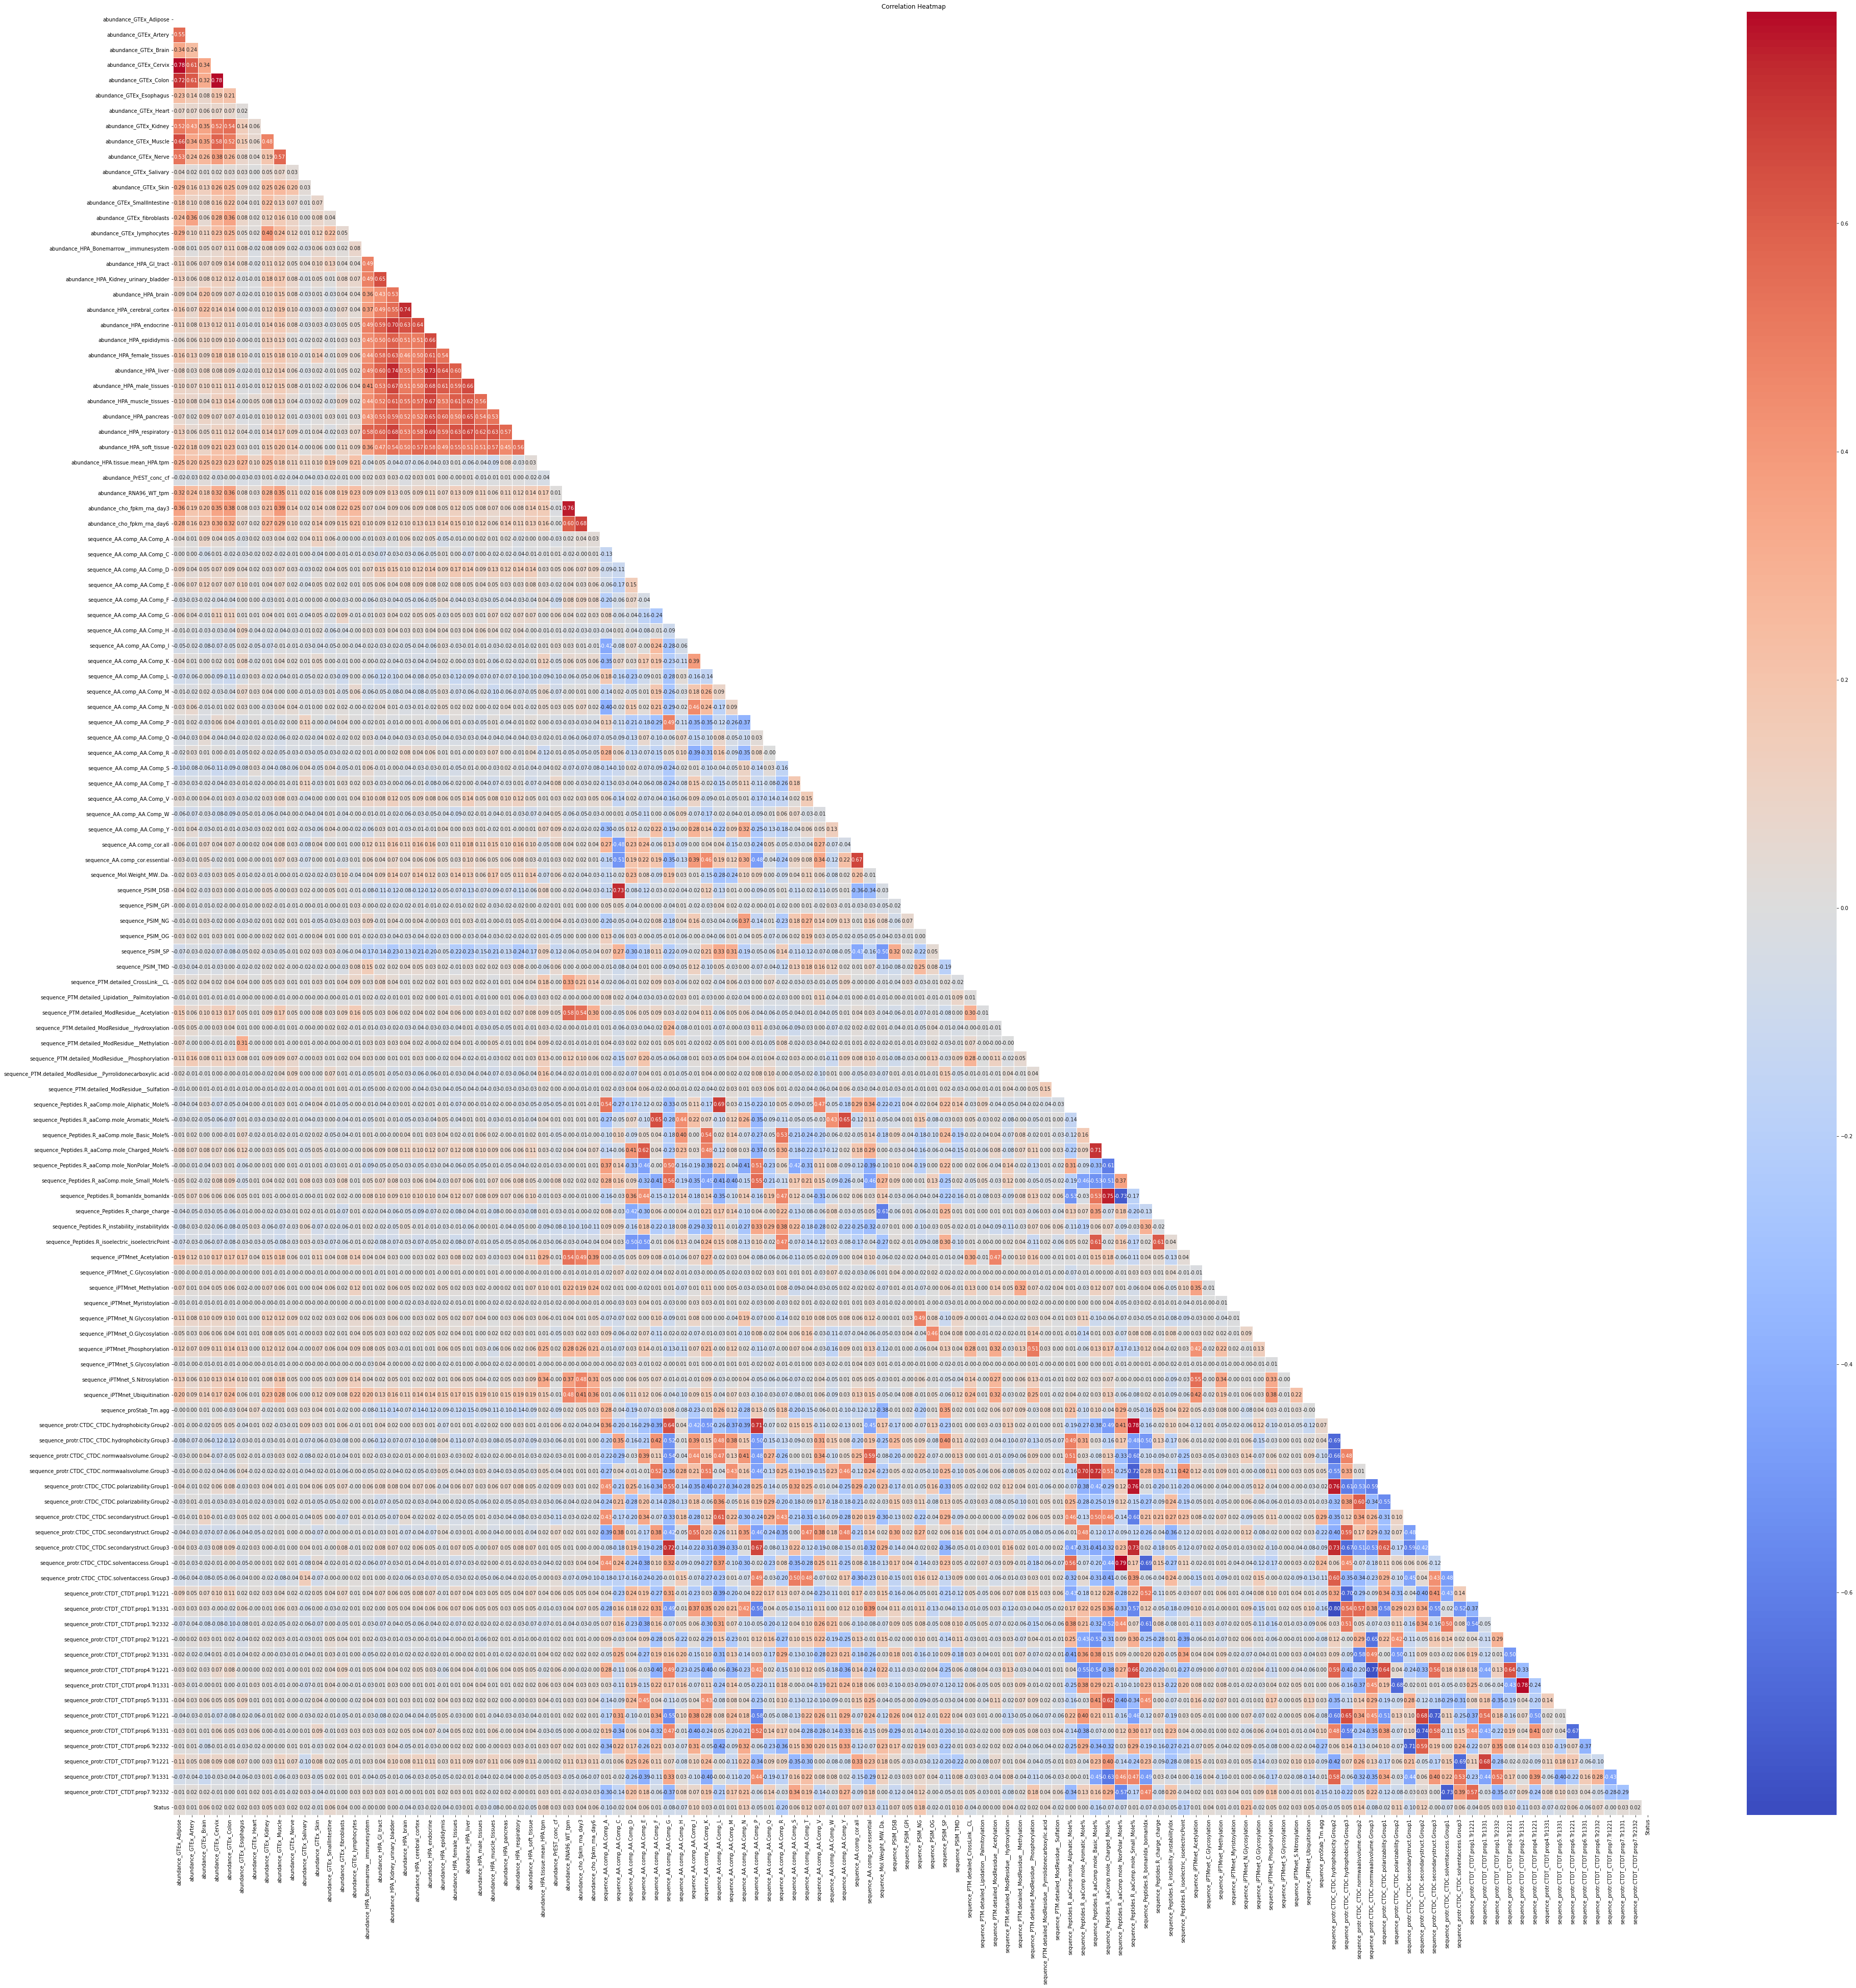

In [15]:
show_heatmap(df=X_stand_df, target='Status', predictor_list=predictor_list, title='Correlation Heatmap', figsize=(65,65))

### Look at t-SNE, is there any structure at all?
If not, maybe this won't work.

Hmm. This really looks like noise, but lets see

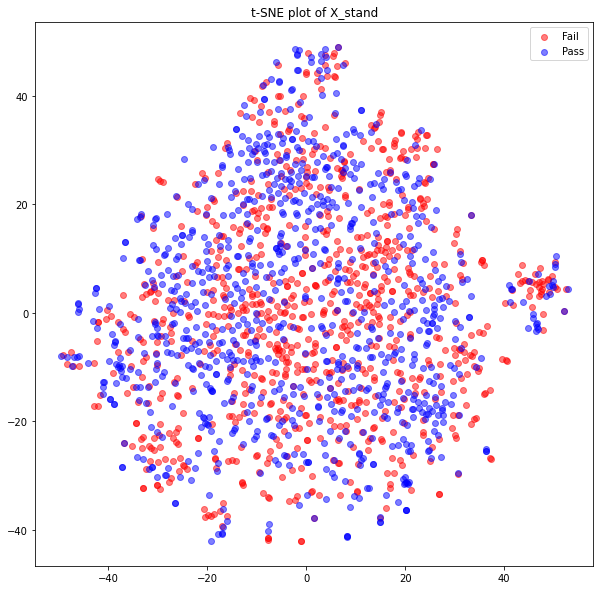

In [16]:
# create a t-sne plot of the data in new_df colored by the 'Status' column
t_sne_plot(X_stand, df_merged['Status'], title='t-SNE plot of X_stand')

### Data splitting strategy

In [17]:
df_merged['Status'].astype(int)
df_merged.shape

(1760, 171)

In [18]:
# Shuffle the rows and split the data into training, validation, calibration, and testing sets

# Step 1: Split the data into training (70%) and temporary (30%) sets
train_df, tmp_df = train_test_split(df_merged, test_size=0.3, random_state=1, stratify=df_merged['Status'])
# train_df: 70% of the data, used for training the model
# tmp_df: 30% of the data, used for further splitting into validation and testing sets

# Step 2: Split the temporary set into validation (20% of the original) and testing (10% of the original) sets
tmp2_df, test_df = train_test_split(tmp_df, test_size=0.33, random_state=1, stratify=tmp_df['Status'])
# tmp2_df: ~20% of the original data, used for further splitting into validation and calibration sets
# test_df: ~10% of the original data, used for final model testing

# Step 3: Split the tmp2_df data into validation (10% of the original) and calibration (10% of the original) sets
val_df, cal_df = train_test_split(tmp2_df, test_size=0.5, random_state=1, stratify=tmp2_df['Status'])
# val_df: ~10% of the original data, used for model validation during training
# cal_df: ~10% of the original data, used for model calibration or hyperparameter tuning

# Display the shapes of the resulting datasets
train_df.shape, val_df.shape, cal_df.shape, test_df.shape

((1232, 171), (176, 171), (177, 171), (175, 171))

In [19]:
# check the distribution of 'Status' in train_df, val_df, cal_df, and test_df
display(train_df['Status'].groupby(train_df['Status']).count())
display(val_df['Status'].groupby(val_df['Status']).count())
display(cal_df['Status'].groupby(cal_df['Status']).count())
display(test_df['Status'].groupby(test_df['Status']).count())


Status
0    613
1    619
Name: Status, dtype: int64

Status
0    88
1    88
Name: Status, dtype: int64

Status
0    88
1    89
Name: Status, dtype: int64

Status
0    87
1    88
Name: Status, dtype: int64

## Train catboost

In [20]:


def get_data():
    y = train_df['Status'].values.astype(int)  # Ensure the target values are integers
    X = train_df[predictor_list].values
    return X, y

# Objective function for Optuna
def objective(trial: optuna.Trial) -> float:
    X, y = get_data()
    train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=0.25, stratify=y)
    
    # Suggest classifier
    classifier_name = trial.suggest_categorical("classifier", ["CatBoost", "XGBoost", "RandomForest", "LogisticRegression"])
    
    if classifier_name == "CatBoost":
        param = {
            "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
            "colsample_bylevel": trial.suggest_float("cat_colsample_bylevel", 0.01, 0.1, log=True),
            "depth": trial.suggest_int("cat_depth", 1, 12),
            "boosting_type": trial.suggest_categorical("cat_boosting_type", ["Ordered", "Plain"]),
            "bootstrap_type": trial.suggest_categorical("cat_bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
            "used_ram_limit": "3gb",
            "eval_metric": "AUC",
        }
        if param["bootstrap_type"] == "Bayesian":
            param["bagging_temperature"] = trial.suggest_float("cat_bagging_temperature", 0, 10)
        elif param["bootstrap_type"] == "Bernoulli":
            param["subsample"] = trial.suggest_float("cat_subsample", 0.1, 1, log=True)

        gbm = cb.CatBoostClassifier(**param)
        pruning_callback = CatBoostPruningCallback(trial, "AUC")
        gbm.fit(
            train_x,
            train_y,
            eval_set=[(valid_x, valid_y)],
            verbose=0,
            early_stopping_rounds=100,
            callbacks=[pruning_callback],
        )
        pruning_callback.check_pruned()
        preds = gbm.predict(valid_x)
        
    elif classifier_name == "XGBoost":
        param = {
            "objective": "binary:logistic",
            "colsample_bytree": trial.suggest_float("xgb_colsample_bytree", 0.5, 1.0),
            "learning_rate": trial.suggest_float("xgb_learning_rate", 0.01, 0.1),
            "max_depth": trial.suggest_int("xgb_max_depth", 1, 12),
            "n_estimators": trial.suggest_int("xgb_n_estimators", 100, 1000),
            "subsample": trial.suggest_float("xgb_subsample", 0.5, 1.0),
        }
        gbm = xgb.XGBClassifier(**param)
        gbm.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], early_stopping_rounds=100, verbose=False)
        preds = gbm.predict(valid_x)
        
    elif classifier_name == "RandomForest":
        param = {
            "n_estimators": trial.suggest_int("rf_n_estimators", 100, 1000),
            "max_depth": trial.suggest_int("rf_max_depth", 1, 12),
            "min_samples_split": trial.suggest_int("rf_min_samples_split", 2, 10),
            "min_samples_leaf": trial.suggest_int("rf_min_samples_leaf", 1, 10),
            "bootstrap": trial.suggest_categorical("rf_bootstrap", [True, False]),
        }
        gbm = RandomForestClassifier(**param)
        gbm.fit(train_x, train_y)
        preds = gbm.predict(valid_x)
        
    elif classifier_name == "LogisticRegression":
        param = {
            "C": trial.suggest_float("lr_C", 1e-6, 1e2, log=True),
            "max_iter": trial.suggest_int("lr_max_iter", 100, 1000),
            "solver": trial.suggest_categorical("lr_solver", ["lbfgs", "liblinear", "sag", "saga"]),
        }
        gbm = LogisticRegression(**param)
        gbm.fit(train_x, train_y)
        preds = gbm.predict(valid_x)


    pred_labels = np.rint(preds).astype(int) # Ensure binary format (0 or 1)
    valid_y = valid_y.astype(int)
    accuracy = accuracy_score(valid_y, pred_labels)
    return accuracy

In [21]:
# Optuna Study

import warnings
warnings.filterwarnings("ignore")

study = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="maximize"
)
study.optimize(objective, n_trials=300, timeout=1800)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-07-26 15:42:47,083] A new study created in memory with name: no-name-666fe896-c564-4651-98a5-db9931eb8839
[I 2024-07-26 15:42:47,331] Trial 0 finished with value: 0.5 and parameters: {'classifier': 'LogisticRegression', 'lr_C': 1.0716771448750828e-06, 'lr_max_iter': 250, 'lr_solver': 'sag'}. Best is trial 0 with value: 0.5.
[I 2024-07-26 15:42:47,927] Trial 1 finished with value: 0.7305194805194806 and parameters: {'classifier': 'CatBoost', 'objective': 'CrossEntropy', 'cat_colsample_bylevel': 0.058671279111930194, 'cat_depth': 3, 'cat_boosting_type': 'Plain', 'cat_bootstrap_type': 'Bayesian', 'cat_bagging_temperature': 0.1710618047456114}. Best is trial 1 with value: 0.7305194805194806.


[15:42:47] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:42:48,729] Trial 2 finished with value: 0.6688311688311688 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.7462394369494021, 'xgb_learning_rate': 0.072875673042207, 'xgb_max_depth': 5, 'xgb_n_estimators': 825, 'xgb_subsample': 0.9878860676837491}. Best is trial 1 with value: 0.7305194805194806.
[I 2024-07-26 15:43:44,543] Trial 3 finished with value: 0.6818181818181818 and parameters: {'classifier': 'CatBoost', 'objective': 'CrossEntropy', 'cat_colsample_bylevel': 0.05249496660870396, 'cat_depth': 12, 'cat_boosting_type': 'Ordered', 'cat_bootstrap_type': 'Bayesian', 'cat_bagging_temperature': 9.69725327640441}. Best is trial 1 with value: 0.7305194805194806.
[I 2024-07-26 15:43:44,576] Trial 4 finished with value: 0.6006493506493507 and parameters: {'classifier': 'LogisticRegression', 'lr_C': 0.0001900697111050634, 'lr_max_iter': 481, 'lr_solver': 'liblinear'}. Best is trial 1 with value: 0.7305194805194806.
[I 2024-07-26 15:43:46,284] Trial 5 finis

[15:43:46] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:43:46,927] Trial 7 finished with value: 0.6655844155844156 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.6861393161301557, 'xgb_learning_rate': 0.08625389560723991, 'xgb_max_depth': 6, 'xgb_n_estimators': 877, 'xgb_subsample': 0.9449422293048659}. Best is trial 1 with value: 0.7305194805194806.
[I 2024-07-26 15:43:47,435] Trial 8 finished with value: 0.6915584415584416 and parameters: {'classifier': 'CatBoost', 'objective': 'Logloss', 'cat_colsample_bylevel': 0.03215308794169052, 'cat_depth': 7, 'cat_boosting_type': 'Plain', 'cat_bootstrap_type': 'MVS'}. Best is trial 1 with value: 0.7305194805194806.
[I 2024-07-26 15:43:47,707] Trial 9 finished with value: 0.5 and parameters: {'classifier': 'LogisticRegression', 'lr_C': 1.4356085137648541e-05, 'lr_max_iter': 348, 'lr_solver': 'saga'}. Best is trial 1 with value: 0.7305194805194806.
[I 2024-07-26 15:43:50,436] Trial 10 finished with value: 0.6655844155844156 and parameters: {'classifier': 'RandomF

[15:43:55] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:43:56,624] Trial 17 finished with value: 0.7207792207792207 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9740270932473218, 'xgb_learning_rate': 0.010877870335069616, 'xgb_max_depth': 12, 'xgb_n_estimators': 117, 'xgb_subsample': 0.5636691486164997}. Best is trial 1 with value: 0.7305194805194806.


[15:43:56] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:43:57,435] Trial 18 finished with value: 0.7012987012987013 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9911764284771681, 'xgb_learning_rate': 0.012442663462730883, 'xgb_max_depth': 12, 'xgb_n_estimators': 158, 'xgb_subsample': 0.5201846464570443}. Best is trial 1 with value: 0.7305194805194806.


[15:43:57] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:43:57,987] Trial 19 finished with value: 0.6623376623376623 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9916028564104583, 'xgb_learning_rate': 0.010249062430962418, 'xgb_max_depth': 12, 'xgb_n_estimators': 100, 'xgb_subsample': 0.5387418376960224}. Best is trial 1 with value: 0.7305194805194806.


[15:43:58] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:43:58,406] Trial 20 finished with value: 0.6948051948051948 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.5750700209974504, 'xgb_learning_rate': 0.044094187335661665, 'xgb_max_depth': 1, 'xgb_n_estimators': 423, 'xgb_subsample': 0.6914929207332907}. Best is trial 1 with value: 0.7305194805194806.
[I 2024-07-26 15:43:59,142] Trial 21 finished with value: 0.6428571428571429 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 499, 'rf_max_depth': 1, 'rf_min_samples_split': 10, 'rf_min_samples_leaf': 5, 'rf_bootstrap': True}. Best is trial 1 with value: 0.7305194805194806.
[I 2024-07-26 15:43:59,401] Trial 22 pruned. Trial was pruned at iteration 43.


[15:43:59] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:44:00,375] Trial 23 finished with value: 0.6785714285714286 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8693669113404812, 'xgb_learning_rate': 0.04376899342274021, 'xgb_max_depth': 9, 'xgb_n_estimators': 493, 'xgb_subsample': 0.7040325110867757}. Best is trial 1 with value: 0.7305194805194806.
[I 2024-07-26 15:44:03,372] Trial 24 finished with value: 0.6525974025974026 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 787, 'rf_max_depth': 8, 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 7, 'rf_bootstrap': True}. Best is trial 1 with value: 0.7305194805194806.


[15:44:03] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:44:04,988] Trial 25 finished with value: 0.6753246753246753 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8546417598477558, 'xgb_learning_rate': 0.02740633209790618, 'xgb_max_depth': 9, 'xgb_n_estimators': 347, 'xgb_subsample': 0.8245372423338704}. Best is trial 1 with value: 0.7305194805194806.
[I 2024-07-26 15:44:05,077] Trial 26 pruned. Trial was pruned at iteration 5.
[I 2024-07-26 15:44:05,435] Trial 27 finished with value: 0.5746753246753247 and parameters: {'classifier': 'LogisticRegression', 'lr_C': 57.60186200340832, 'lr_max_iter': 953, 'lr_solver': 'lbfgs'}. Best is trial 1 with value: 0.7305194805194806.


[15:44:05] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:44:05,986] Trial 28 finished with value: 0.6363636363636364 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.507099574455566, 'xgb_learning_rate': 0.06274939987125816, 'xgb_max_depth': 2, 'xgb_n_estimators': 255, 'xgb_subsample': 0.6141249083583062}. Best is trial 1 with value: 0.7305194805194806.
[I 2024-07-26 15:44:06,455] Trial 29 finished with value: 0.5811688311688312 and parameters: {'classifier': 'LogisticRegression', 'lr_C': 1.8897505416240554, 'lr_max_iter': 853, 'lr_solver': 'lbfgs'}. Best is trial 1 with value: 0.7305194805194806.
[I 2024-07-26 15:44:06,591] Trial 30 pruned. Trial was pruned at iteration 5.


[15:44:06] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:44:07,851] Trial 31 finished with value: 0.7045454545454546 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9962232768025054, 'xgb_learning_rate': 0.012039401787764272, 'xgb_max_depth': 12, 'xgb_n_estimators': 138, 'xgb_subsample': 0.5011260590261883}. Best is trial 1 with value: 0.7305194805194806.


[15:44:07] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:44:09,121] Trial 32 finished with value: 0.7272727272727273 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8878382347840553, 'xgb_learning_rate': 0.026450825274302203, 'xgb_max_depth': 10, 'xgb_n_estimators': 655, 'xgb_subsample': 0.5097375402804093}. Best is trial 1 with value: 0.7305194805194806.


[15:44:09] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:44:09,976] Trial 33 finished with value: 0.6525974025974026 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8728927706436457, 'xgb_learning_rate': 0.02985652852407082, 'xgb_max_depth': 9, 'xgb_n_estimators': 726, 'xgb_subsample': 0.6248314244595072}. Best is trial 1 with value: 0.7305194805194806.


[15:44:10] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:44:10,938] Trial 34 finished with value: 0.6298701298701299 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9072789822429876, 'xgb_learning_rate': 0.02971122027386657, 'xgb_max_depth': 10, 'xgb_n_estimators': 658, 'xgb_subsample': 0.6044816210088055}. Best is trial 1 with value: 0.7305194805194806.


[15:44:10] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:44:12,190] Trial 35 finished with value: 0.6948051948051948 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.7877478583646211, 'xgb_learning_rate': 0.024162433370060847, 'xgb_max_depth': 10, 'xgb_n_estimators': 599, 'xgb_subsample': 0.8146990557972734}. Best is trial 1 with value: 0.7305194805194806.
[I 2024-07-26 15:44:13,663] Trial 36 finished with value: 0.6493506493506493 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 322, 'rf_max_depth': 5, 'rf_min_samples_split': 4, 'rf_min_samples_leaf': 2, 'rf_bootstrap': False}. Best is trial 1 with value: 0.7305194805194806.
[I 2024-07-26 15:44:13,747] Trial 37 pruned. Trial was pruned at iteration 5.
[I 2024-07-26 15:44:14,252] Trial 38 finished with value: 0.5064935064935064 and parameters: {'classifier': 'LogisticRegression', 'lr_C': 0.02228615039044264, 'lr_max_iter': 692, 'lr_solver': 'sag'}. Best is trial 1 with value: 0.7305194805194806.


[15:44:14] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:44:15,009] Trial 39 finished with value: 0.6688311688311688 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9286396916889037, 'xgb_learning_rate': 0.044166974149897044, 'xgb_max_depth': 7, 'xgb_n_estimators': 730, 'xgb_subsample': 0.5774624262479693}. Best is trial 1 with value: 0.7305194805194806.
[I 2024-07-26 15:44:15,145] Trial 40 pruned. Trial was pruned at iteration 5.


[15:44:15] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:44:16,673] Trial 41 finished with value: 0.7012987012987013 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9569639533586165, 'xgb_learning_rate': 0.010582363617132155, 'xgb_max_depth': 12, 'xgb_n_estimators': 240, 'xgb_subsample': 0.5078058878221421}. Best is trial 1 with value: 0.7305194805194806.


[15:44:16] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:44:18,384] Trial 42 finished with value: 0.6818181818181818 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9984179358198568, 'xgb_learning_rate': 0.019079893307880652, 'xgb_max_depth': 11, 'xgb_n_estimators': 305, 'xgb_subsample': 0.5045986900613245}. Best is trial 1 with value: 0.7305194805194806.


[15:44:18] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:44:19,151] Trial 43 finished with value: 0.6396103896103896 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8086344643322219, 'xgb_learning_rate': 0.03607496571855364, 'xgb_max_depth': 11, 'xgb_n_estimators': 490, 'xgb_subsample': 0.5664689210509953}. Best is trial 1 with value: 0.7305194805194806.


[15:44:19] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:44:20,103] Trial 44 finished with value: 0.6818181818181818 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9320669561456, 'xgb_learning_rate': 0.019766594296822988, 'xgb_max_depth': 8, 'xgb_n_estimators': 174, 'xgb_subsample': 0.6772734129669253}. Best is trial 1 with value: 0.7305194805194806.
[I 2024-07-26 15:44:22,782] Trial 45 finished with value: 0.6623376623376623 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 683, 'rf_max_depth': 9, 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 8, 'rf_bootstrap': True}. Best is trial 1 with value: 0.7305194805194806.


[15:44:22] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:44:24,596] Trial 46 finished with value: 0.6818181818181818 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9409128846568242, 'xgb_learning_rate': 0.019662557106039185, 'xgb_max_depth': 11, 'xgb_n_estimators': 997, 'xgb_subsample': 0.5654132717846867}. Best is trial 1 with value: 0.7305194805194806.
[I 2024-07-26 15:44:24,692] Trial 47 pruned. Trial was pruned at iteration 5.
[I 2024-07-26 15:44:26,068] Trial 48 finished with value: 0.6688311688311688 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 368, 'rf_max_depth': 4, 'rf_min_samples_split': 3, 'rf_min_samples_leaf': 4, 'rf_bootstrap': False}. Best is trial 1 with value: 0.7305194805194806.
[I 2024-07-26 15:44:26,144] Trial 49 finished with value: 0.5909090909090909 and parameters: {'classifier': 'LogisticRegression', 'lr_C': 0.048988871836911974, 'lr_max_iter': 118, 'lr_solver': 'liblinear'}. Best is trial 1 with value: 0.7305194805194806.


[15:44:26] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:44:27,582] Trial 50 finished with value: 0.7175324675324676 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8883579392534623, 'xgb_learning_rate': 0.03609851285066392, 'xgb_max_depth': 4, 'xgb_n_estimators': 411, 'xgb_subsample': 0.653344889905226}. Best is trial 1 with value: 0.7305194805194806.


[15:44:27] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:44:27,926] Trial 51 finished with value: 0.6623376623376623 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8855268003333873, 'xgb_learning_rate': 0.037585742412244424, 'xgb_max_depth': 4, 'xgb_n_estimators': 100, 'xgb_subsample': 0.6397885755420465}. Best is trial 1 with value: 0.7305194805194806.


[15:44:27] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:44:28,353] Trial 52 finished with value: 0.6525974025974026 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9629910876921168, 'xgb_learning_rate': 0.056225704571871836, 'xgb_max_depth': 3, 'xgb_n_estimators': 381, 'xgb_subsample': 0.5584055112384081}. Best is trial 1 with value: 0.7305194805194806.


[15:44:28] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:44:29,517] Trial 53 finished with value: 0.6883116883116883 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8255728570959592, 'xgb_learning_rate': 0.016957740861718175, 'xgb_max_depth': 12, 'xgb_n_estimators': 219, 'xgb_subsample': 0.5015223732484435}. Best is trial 1 with value: 0.7305194805194806.


[15:44:29] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:44:30,200] Trial 54 finished with value: 0.6948051948051948 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.6980233627788941, 'xgb_learning_rate': 0.03539970659923035, 'xgb_max_depth': 6, 'xgb_n_estimators': 568, 'xgb_subsample': 0.7688648090822879}. Best is trial 1 with value: 0.7305194805194806.
[I 2024-07-26 15:44:33,642] Trial 55 finished with value: 0.672077922077922 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 838, 'rf_max_depth': 10, 'rf_min_samples_split': 6, 'rf_min_samples_leaf': 6, 'rf_bootstrap': True}. Best is trial 1 with value: 0.7305194805194806.


[15:44:33] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:44:35,070] Trial 56 finished with value: 0.7045454545454546 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9024925213284702, 'xgb_learning_rate': 0.02425629388589399, 'xgb_max_depth': 10, 'xgb_n_estimators': 459, 'xgb_subsample': 0.653699931994222}. Best is trial 1 with value: 0.7305194805194806.
[I 2024-07-26 15:44:35,185] Trial 57 pruned. Trial was pruned at iteration 5.


[15:44:35] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:44:36,863] Trial 58 finished with value: 0.698051948051948 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9591993205048448, 'xgb_learning_rate': 0.016810214493158296, 'xgb_max_depth': 4, 'xgb_n_estimators': 647, 'xgb_subsample': 0.5802618999549739}. Best is trial 1 with value: 0.7305194805194806.
[I 2024-07-26 15:44:38,186] Trial 59 finished with value: 0.6396103896103896 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 353, 'rf_max_depth': 7, 'rf_min_samples_split': 9, 'rf_min_samples_leaf': 10, 'rf_bootstrap': True}. Best is trial 1 with value: 0.7305194805194806.


[15:44:38] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:44:39,489] Trial 60 finished with value: 0.685064935064935 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8465497205958858, 'xgb_learning_rate': 0.03119259097191147, 'xgb_max_depth': 11, 'xgb_n_estimators': 298, 'xgb_subsample': 0.5428229380611275}. Best is trial 1 with value: 0.7305194805194806.


[15:44:39] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:44:41,619] Trial 61 finished with value: 0.7012987012987013 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9098560694520692, 'xgb_learning_rate': 0.025155152856369926, 'xgb_max_depth': 10, 'xgb_n_estimators': 455, 'xgb_subsample': 0.6744198257807412}. Best is trial 1 with value: 0.7305194805194806.


[15:44:41] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:44:44,608] Trial 62 finished with value: 0.685064935064935 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9057929461468979, 'xgb_learning_rate': 0.021590815550226086, 'xgb_max_depth': 8, 'xgb_n_estimators': 519, 'xgb_subsample': 0.7497600269115491}. Best is trial 1 with value: 0.7305194805194806.


[15:44:44] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:44:46,573] Trial 63 finished with value: 0.6655844155844156 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9707899630609091, 'xgb_learning_rate': 0.014294210385284181, 'xgb_max_depth': 10, 'xgb_n_estimators': 380, 'xgb_subsample': 0.646922767165588}. Best is trial 1 with value: 0.7305194805194806.


[15:44:46] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:44:47,230] Trial 64 finished with value: 0.6883116883116883 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.7643429593159339, 'xgb_learning_rate': 0.09787335481956289, 'xgb_max_depth': 5, 'xgb_n_estimators': 162, 'xgb_subsample': 0.5971595219302975}. Best is trial 1 with value: 0.7305194805194806.
[I 2024-07-26 15:44:47,384] Trial 65 pruned. Trial was pruned at iteration 5.


[15:44:47] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:44:48,870] Trial 66 finished with value: 0.6785714285714286 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9001315241807997, 'xgb_learning_rate': 0.024533326088961437, 'xgb_max_depth': 11, 'xgb_n_estimators': 774, 'xgb_subsample': 0.7286855406304078}. Best is trial 1 with value: 0.7305194805194806.
[I 2024-07-26 15:44:49,550] Trial 67 finished with value: 0.5032467532467533 and parameters: {'classifier': 'LogisticRegression', 'lr_C': 0.0006422775443952816, 'lr_max_iter': 660, 'lr_solver': 'saga'}. Best is trial 1 with value: 0.7305194805194806.
[I 2024-07-26 15:44:51,069] Trial 68 finished with value: 0.6688311688311688 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 671, 'rf_max_depth': 2, 'rf_min_samples_split': 7, 'rf_min_samples_leaf': 3, 'rf_bootstrap': False}. Best is trial 1 with value: 0.7305194805194806.


[15:44:51] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:44:51,839] Trial 69 finished with value: 0.6883116883116883 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.929158647334691, 'xgb_learning_rate': 0.049542115881291, 'xgb_max_depth': 7, 'xgb_n_estimators': 619, 'xgb_subsample': 0.5363360714047396}. Best is trial 1 with value: 0.7305194805194806.
[I 2024-07-26 15:44:51,926] Trial 70 pruned. Trial was pruned at iteration 5.


[15:44:51] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:44:53,259] Trial 71 finished with value: 0.685064935064935 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9980110891767344, 'xgb_learning_rate': 0.01070890900882778, 'xgb_max_depth': 12, 'xgb_n_estimators': 157, 'xgb_subsample': 0.5247387672987334}. Best is trial 1 with value: 0.7305194805194806.


[15:44:53] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:44:53,972] Trial 72 finished with value: 0.7337662337662337 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9814967783735435, 'xgb_learning_rate': 0.013966142109454766, 'xgb_max_depth': 12, 'xgb_n_estimators': 112, 'xgb_subsample': 0.538492236190283}. Best is trial 72 with value: 0.7337662337662337.


[15:44:54] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:44:54,712] Trial 73 finished with value: 0.6363636363636364 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9719698722568603, 'xgb_learning_rate': 0.016023556478282727, 'xgb_max_depth': 12, 'xgb_n_estimators': 106, 'xgb_subsample': 0.5402219069381612}. Best is trial 72 with value: 0.7337662337662337.


[15:44:54] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:44:55,953] Trial 74 finished with value: 0.6525974025974026 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9447336392107866, 'xgb_learning_rate': 0.014379764541833002, 'xgb_max_depth': 12, 'xgb_n_estimators': 195, 'xgb_subsample': 0.5899572573833621}. Best is trial 72 with value: 0.7337662337662337.


[15:44:55] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:44:57,026] Trial 75 finished with value: 0.6558441558441559 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9840649119343144, 'xgb_learning_rate': 0.01033890264238992, 'xgb_max_depth': 11, 'xgb_n_estimators': 137, 'xgb_subsample': 0.9098396812734979}. Best is trial 72 with value: 0.7337662337662337.


[15:44:57] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:44:57,698] Trial 76 finished with value: 0.6818181818181818 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8456867575448473, 'xgb_learning_rate': 0.07113793673040911, 'xgb_max_depth': 12, 'xgb_n_estimators': 269, 'xgb_subsample': 0.5373880260714916}. Best is trial 72 with value: 0.7337662337662337.


[15:44:57] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:44:58,558] Trial 77 finished with value: 0.685064935064935 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.6247850240042805, 'xgb_learning_rate': 0.033659722376709056, 'xgb_max_depth': 10, 'xgb_n_estimators': 544, 'xgb_subsample': 0.6583126178344223}. Best is trial 72 with value: 0.7337662337662337.
[I 2024-07-26 15:45:02,023] Trial 78 finished with value: 0.6785714285714286 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 1000, 'rf_max_depth': 6, 'rf_min_samples_split': 5, 'rf_min_samples_leaf': 6, 'rf_bootstrap': True}. Best is trial 72 with value: 0.7337662337662337.
[I 2024-07-26 15:45:02,089] Trial 79 pruned. Trial was pruned at iteration 5.


[15:45:02] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:45:03,535] Trial 80 finished with value: 0.7045454545454546 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8789646732550398, 'xgb_learning_rate': 0.024225858741682732, 'xgb_max_depth': 9, 'xgb_n_estimators': 425, 'xgb_subsample': 0.6260328120557576}. Best is trial 72 with value: 0.7337662337662337.


[15:45:03] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:45:05,530] Trial 81 finished with value: 0.7272727272727273 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8821953330708633, 'xgb_learning_rate': 0.023214647783992882, 'xgb_max_depth': 9, 'xgb_n_estimators': 423, 'xgb_subsample': 0.6266137896503619}. Best is trial 72 with value: 0.7337662337662337.


[15:45:05] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:45:06,703] Trial 82 finished with value: 0.6883116883116883 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.919386102031737, 'xgb_learning_rate': 0.027212391553441743, 'xgb_max_depth': 8, 'xgb_n_estimators': 360, 'xgb_subsample': 0.5216379320949931}. Best is trial 72 with value: 0.7337662337662337.


[15:45:06] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:45:07,864] Trial 83 finished with value: 0.6396103896103896 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8838304456243523, 'xgb_learning_rate': 0.021491402433892116, 'xgb_max_depth': 1, 'xgb_n_estimators': 471, 'xgb_subsample': 0.704558149134031}. Best is trial 72 with value: 0.7337662337662337.


[15:45:07] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:45:11,064] Trial 84 finished with value: 0.7077922077922078 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8629502746525869, 'xgb_learning_rate': 0.015587235598062087, 'xgb_max_depth': 9, 'xgb_n_estimators': 411, 'xgb_subsample': 0.6131354135992091}. Best is trial 72 with value: 0.7337662337662337.
[I 2024-07-26 15:45:11,708] Trial 85 finished with value: 0.5064935064935064 and parameters: {'classifier': 'LogisticRegression', 'lr_C': 1.3656057441826317, 'lr_max_iter': 542, 'lr_solver': 'sag'}. Best is trial 72 with value: 0.7337662337662337.


[15:45:11] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:45:13,983] Trial 86 finished with value: 0.672077922077922 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.7282118724354527, 'xgb_learning_rate': 0.014480417736854068, 'xgb_max_depth': 8, 'xgb_n_estimators': 328, 'xgb_subsample': 0.5543663097150001}. Best is trial 72 with value: 0.7337662337662337.


[15:45:14] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:45:16,238] Trial 87 finished with value: 0.6915584415584416 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8209434057601301, 'xgb_learning_rate': 0.014216540282611195, 'xgb_max_depth': 9, 'xgb_n_estimators': 414, 'xgb_subsample': 0.5942575269096426}. Best is trial 72 with value: 0.7337662337662337.
[I 2024-07-26 15:45:16,856] Trial 88 finished with value: 0.6493506493506493 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 127, 'rf_max_depth': 10, 'rf_min_samples_split': 7, 'rf_min_samples_leaf': 8, 'rf_bootstrap': True}. Best is trial 72 with value: 0.7337662337662337.


[15:45:16] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:45:17,378] Trial 89 finished with value: 0.6493506493506493 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8659702800696818, 'xgb_learning_rate': 0.029525978472028723, 'xgb_max_depth': 2, 'xgb_n_estimators': 699, 'xgb_subsample': 0.6147954781916506}. Best is trial 72 with value: 0.7337662337662337.
[I 2024-07-26 15:45:17,538] Trial 90 pruned. Trial was pruned at iteration 5.


[15:45:17] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:45:18,998] Trial 91 finished with value: 0.6948051948051948 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8503100971138559, 'xgb_learning_rate': 0.040314401717450175, 'xgb_max_depth': 10, 'xgb_n_estimators': 429, 'xgb_subsample': 0.6404727287861055}. Best is trial 72 with value: 0.7337662337662337.


[15:45:19] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:45:20,233] Trial 92 finished with value: 0.6785714285714286 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8952229780408236, 'xgb_learning_rate': 0.021020334335965535, 'xgb_max_depth': 9, 'xgb_n_estimators': 514, 'xgb_subsample': 0.500326842264605}. Best is trial 72 with value: 0.7337662337662337.


[15:45:20] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:45:21,388] Trial 93 finished with value: 0.7045454545454546 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9782277225241114, 'xgb_learning_rate': 0.019274695475966018, 'xgb_max_depth': 11, 'xgb_n_estimators': 196, 'xgb_subsample': 0.5752034627192826}. Best is trial 72 with value: 0.7337662337662337.


[15:45:21] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:45:23,028] Trial 94 finished with value: 0.7305194805194806 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9494364634526017, 'xgb_learning_rate': 0.027044111501424554, 'xgb_max_depth': 10, 'xgb_n_estimators': 862, 'xgb_subsample': 0.6129779814604049}. Best is trial 72 with value: 0.7337662337662337.


[15:45:23] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:45:26,084] Trial 95 finished with value: 0.6883116883116883 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9510882569150756, 'xgb_learning_rate': 0.010224185909510027, 'xgb_max_depth': 11, 'xgb_n_estimators': 879, 'xgb_subsample': 0.6135632242543736}. Best is trial 72 with value: 0.7337662337662337.


[15:45:26] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:45:27,495] Trial 96 finished with value: 0.685064935064935 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9957635870213, 'xgb_learning_rate': 0.02716198735547387, 'xgb_max_depth': 12, 'xgb_n_estimators': 906, 'xgb_subsample': 0.5571060263609934}. Best is trial 72 with value: 0.7337662337662337.


[15:45:27] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:45:28,921] Trial 97 finished with value: 0.7012987012987013 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9404497313401884, 'xgb_learning_rate': 0.018386692335313613, 'xgb_max_depth': 9, 'xgb_n_estimators': 796, 'xgb_subsample': 0.5254556267878607}. Best is trial 72 with value: 0.7337662337662337.
[I 2024-07-26 15:45:30,874] Trial 98 finished with value: 0.6818181818181818 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 443, 'rf_max_depth': 5, 'rf_min_samples_split': 9, 'rf_min_samples_leaf': 8, 'rf_bootstrap': False}. Best is trial 72 with value: 0.7337662337662337.


[15:45:30] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:45:31,713] Trial 99 finished with value: 0.6428571428571429 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9281010279572685, 'xgb_learning_rate': 0.03249200043619369, 'xgb_max_depth': 10, 'xgb_n_estimators': 136, 'xgb_subsample': 0.6232619024475416}. Best is trial 72 with value: 0.7337662337662337.
[I 2024-07-26 15:45:31,813] Trial 100 pruned. Trial was pruned at iteration 5.


[15:45:31] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:45:33,615] Trial 101 finished with value: 0.6655844155844156 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9169298386950389, 'xgb_learning_rate': 0.02318428409183365, 'xgb_max_depth': 10, 'xgb_n_estimators': 393, 'xgb_subsample': 0.6550089178694608}. Best is trial 72 with value: 0.7337662337662337.


[15:45:33] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:45:35,164] Trial 102 finished with value: 0.7012987012987013 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8649836544642503, 'xgb_learning_rate': 0.016936658859150643, 'xgb_max_depth': 7, 'xgb_n_estimators': 460, 'xgb_subsample': 0.6774122372019065}. Best is trial 72 with value: 0.7337662337662337.


[15:45:35] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:45:36,375] Trial 103 finished with value: 0.672077922077922 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9617734654988553, 'xgb_learning_rate': 0.027864530999387942, 'xgb_max_depth': 11, 'xgb_n_estimators': 578, 'xgb_subsample': 0.6029736869853022}. Best is trial 72 with value: 0.7337662337662337.


[15:45:36] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:45:37,841] Trial 104 finished with value: 0.6818181818181818 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9809834056620809, 'xgb_learning_rate': 0.012055744760912965, 'xgb_max_depth': 10, 'xgb_n_estimators': 235, 'xgb_subsample': 0.578564225682849}. Best is trial 72 with value: 0.7337662337662337.


[15:45:37] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:45:39,051] Trial 105 finished with value: 0.698051948051948 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8896828202846842, 'xgb_learning_rate': 0.022079698810591568, 'xgb_max_depth': 9, 'xgb_n_estimators': 976, 'xgb_subsample': 0.6316552092061589}. Best is trial 72 with value: 0.7337662337662337.
[I 2024-07-26 15:45:39,383] Trial 106 finished with value: 0.5454545454545454 and parameters: {'classifier': 'LogisticRegression', 'lr_C': 39.19675682446908, 'lr_max_iter': 996, 'lr_solver': 'lbfgs'}. Best is trial 72 with value: 0.7337662337662337.


[15:45:39] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:45:40,144] Trial 107 finished with value: 0.6428571428571429 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9512277285797567, 'xgb_learning_rate': 0.0404626800004822, 'xgb_max_depth': 5, 'xgb_n_estimators': 280, 'xgb_subsample': 0.518093487342165}. Best is trial 72 with value: 0.7337662337662337.


[15:45:40] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:45:40,886] Trial 108 finished with value: 0.698051948051948 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8347600876908633, 'xgb_learning_rate': 0.017833948578011898, 'xgb_max_depth': 11, 'xgb_n_estimators': 119, 'xgb_subsample': 0.69735283703258}. Best is trial 72 with value: 0.7337662337662337.
[I 2024-07-26 15:45:42,078] Trial 109 finished with value: 0.685064935064935 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 256, 'rf_max_depth': 12, 'rf_min_samples_split': 2, 'rf_min_samples_leaf': 5, 'rf_bootstrap': True}. Best is trial 72 with value: 0.7337662337662337.


[15:45:42] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:45:43,613] Trial 110 finished with value: 0.6948051948051948 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9106559070175411, 'xgb_learning_rate': 0.013282053274686954, 'xgb_max_depth': 12, 'xgb_n_estimators': 327, 'xgb_subsample': 0.559181435628676}. Best is trial 72 with value: 0.7337662337662337.


[15:45:43] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:45:44,887] Trial 111 finished with value: 0.6948051948051948 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.873803579301681, 'xgb_learning_rate': 0.02509602972382119, 'xgb_max_depth': 9, 'xgb_n_estimators': 487, 'xgb_subsample': 0.6661393063869112}. Best is trial 72 with value: 0.7337662337662337.


[15:45:44] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:45:46,035] Trial 112 finished with value: 0.672077922077922 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.7931211229227176, 'xgb_learning_rate': 0.024527532563880898, 'xgb_max_depth': 8, 'xgb_n_estimators': 434, 'xgb_subsample': 0.6320018386931114}. Best is trial 72 with value: 0.7337662337662337.


[15:45:46] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:45:47,061] Trial 113 finished with value: 0.685064935064935 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8754361197978558, 'xgb_learning_rate': 0.03042616785594841, 'xgb_max_depth': 9, 'xgb_n_estimators': 410, 'xgb_subsample': 0.607035399526929}. Best is trial 72 with value: 0.7337662337662337.


[15:45:47] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:45:48,559] Trial 114 finished with value: 0.7077922077922078 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8927473968320329, 'xgb_learning_rate': 0.019211099417950815, 'xgb_max_depth': 10, 'xgb_n_estimators': 370, 'xgb_subsample': 0.6459414692081724}. Best is trial 72 with value: 0.7337662337662337.


[15:45:48] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:45:49,841] Trial 115 finished with value: 0.698051948051948 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8995037998198491, 'xgb_learning_rate': 0.01645319946912803, 'xgb_max_depth': 10, 'xgb_n_estimators': 347, 'xgb_subsample': 0.6483009065871391}. Best is trial 72 with value: 0.7337662337662337.
[I 2024-07-26 15:45:49,981] Trial 116 pruned. Trial was pruned at iteration 5.


[15:45:50] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:45:51,011] Trial 117 finished with value: 0.6461038961038961 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9362542261004542, 'xgb_learning_rate': 0.020213238425278557, 'xgb_max_depth': 4, 'xgb_n_estimators': 511, 'xgb_subsample': 0.7202887112714673}. Best is trial 72 with value: 0.7337662337662337.


[15:45:51] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:45:52,381] Trial 118 finished with value: 0.6525974025974026 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9641946183699232, 'xgb_learning_rate': 0.01513471696739508, 'xgb_max_depth': 11, 'xgb_n_estimators': 372, 'xgb_subsample': 0.5121509559674682}. Best is trial 72 with value: 0.7337662337662337.


[15:45:52] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:45:53,218] Trial 119 finished with value: 0.7077922077922078 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9850891783838891, 'xgb_learning_rate': 0.05514466690809215, 'xgb_max_depth': 6, 'xgb_n_estimators': 188, 'xgb_subsample': 0.5473900657649569}. Best is trial 72 with value: 0.7337662337662337.


[15:45:53] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:45:53,984] Trial 120 finished with value: 0.6753246753246753 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.998792794616056, 'xgb_learning_rate': 0.0703778251614755, 'xgb_max_depth': 7, 'xgb_n_estimators': 206, 'xgb_subsample': 0.537554830918124}. Best is trial 72 with value: 0.7337662337662337.


[15:45:54] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:45:54,817] Trial 121 finished with value: 0.6688311688311688 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9820793983002402, 'xgb_learning_rate': 0.05172147045929486, 'xgb_max_depth': 6, 'xgb_n_estimators': 169, 'xgb_subsample': 0.9911656654553003}. Best is trial 72 with value: 0.7337662337662337.


[15:45:54] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:45:55,570] Trial 122 finished with value: 0.6785714285714286 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9235408286960005, 'xgb_learning_rate': 0.05955977133807441, 'xgb_max_depth': 10, 'xgb_n_estimators': 132, 'xgb_subsample': 0.5885002654495598}. Best is trial 72 with value: 0.7337662337662337.


[15:45:55] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:45:56,369] Trial 123 finished with value: 0.6818181818181818 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.969530732736137, 'xgb_learning_rate': 0.04962263729772377, 'xgb_max_depth': 8, 'xgb_n_estimators': 158, 'xgb_subsample': 0.5680380375265754}. Best is trial 72 with value: 0.7337662337662337.


[15:45:56] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:45:57,045] Trial 124 finished with value: 0.6461038961038961 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8611260954943417, 'xgb_learning_rate': 0.06526265036026178, 'xgb_max_depth': 12, 'xgb_n_estimators': 392, 'xgb_subsample': 0.5447024151804475}. Best is trial 72 with value: 0.7337662337662337.
[I 2024-07-26 15:45:59,431] Trial 125 finished with value: 0.7012987012987013 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 553, 'rf_max_depth': 8, 'rf_min_samples_split': 4, 'rf_min_samples_leaf': 1, 'rf_bootstrap': True}. Best is trial 72 with value: 0.7337662337662337.


[15:45:59] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:45:59,975] Trial 126 finished with value: 0.6331168831168831 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9491726680264038, 'xgb_learning_rate': 0.027253824885080342, 'xgb_max_depth': 3, 'xgb_n_estimators': 453, 'xgb_subsample': 0.8098213408332613}. Best is trial 72 with value: 0.7337662337662337.
[I 2024-07-26 15:46:00,144] Trial 127 finished with value: 0.5714285714285714 and parameters: {'classifier': 'LogisticRegression', 'lr_C': 0.001006101002561452, 'lr_max_iter': 728, 'lr_solver': 'liblinear'}. Best is trial 72 with value: 0.7337662337662337.
[I 2024-07-26 15:46:00,307] Trial 128 pruned. Trial was pruned at iteration 5.


[15:46:00] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:46:01,608] Trial 129 finished with value: 0.698051948051948 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9855551987422926, 'xgb_learning_rate': 0.012674330574609946, 'xgb_max_depth': 12, 'xgb_n_estimators': 115, 'xgb_subsample': 0.6825702724430229}. Best is trial 72 with value: 0.7337662337662337.


[15:46:01] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:46:02,266] Trial 130 finished with value: 0.6298701298701299 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.90509091297862, 'xgb_learning_rate': 0.018833800388119167, 'xgb_max_depth': 10, 'xgb_n_estimators': 101, 'xgb_subsample': 0.5496030972214792}. Best is trial 72 with value: 0.7337662337662337.


[15:46:02] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:46:03,924] Trial 131 finished with value: 0.672077922077922 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8853017320991212, 'xgb_learning_rate': 0.02257664795322617, 'xgb_max_depth': 9, 'xgb_n_estimators': 444, 'xgb_subsample': 0.6216309497648728}. Best is trial 72 with value: 0.7337662337662337.


[15:46:03] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:46:05,447] Trial 132 finished with value: 0.6915584415584416 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8845185463939759, 'xgb_learning_rate': 0.025790075808356655, 'xgb_max_depth': 11, 'xgb_n_estimators': 409, 'xgb_subsample': 0.5253009683413513}. Best is trial 72 with value: 0.7337662337662337.


[15:46:05] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:46:06,239] Trial 133 finished with value: 0.6493506493506493 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8551656146081076, 'xgb_learning_rate': 0.056642414524106906, 'xgb_max_depth': 9, 'xgb_n_estimators': 480, 'xgb_subsample': 0.6371325813650485}. Best is trial 72 with value: 0.7337662337662337.


[15:46:06] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:46:07,269] Trial 134 finished with value: 0.6623376623376623 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8384214330138842, 'xgb_learning_rate': 0.03515413216607386, 'xgb_max_depth': 6, 'xgb_n_estimators': 541, 'xgb_subsample': 0.6631352262627317}. Best is trial 72 with value: 0.7337662337662337.


[15:46:07] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:46:09,254] Trial 135 finished with value: 0.6655844155844156 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8739507480528299, 'xgb_learning_rate': 0.012660754133322447, 'xgb_max_depth': 10, 'xgb_n_estimators': 729, 'xgb_subsample': 0.6028825037833595}. Best is trial 72 with value: 0.7337662337662337.


[15:46:09] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:46:10,230] Trial 136 finished with value: 0.6818181818181818 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9177411819746639, 'xgb_learning_rate': 0.020455536750516454, 'xgb_max_depth': 9, 'xgb_n_estimators': 181, 'xgb_subsample': 0.586571860054994}. Best is trial 72 with value: 0.7337662337662337.


[15:46:10] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:46:10,677] Trial 137 finished with value: 0.6818181818181818 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9738019760676538, 'xgb_learning_rate': 0.04640754553911057, 'xgb_max_depth': 4, 'xgb_n_estimators': 146, 'xgb_subsample': 0.5115395898950293}. Best is trial 72 with value: 0.7337662337662337.
[I 2024-07-26 15:46:15,947] Trial 138 finished with value: 0.6655844155844156 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 795, 'rf_max_depth': 10, 'rf_min_samples_split': 7, 'rf_min_samples_leaf': 3, 'rf_bootstrap': False}. Best is trial 72 with value: 0.7337662337662337.


[15:46:15] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:46:16,948] Trial 139 finished with value: 0.672077922077922 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8990690612779481, 'xgb_learning_rate': 0.029307573190840864, 'xgb_max_depth': 5, 'xgb_n_estimators': 355, 'xgb_subsample': 0.9502481867058103}. Best is trial 72 with value: 0.7337662337662337.
[I 2024-07-26 15:46:17,055] Trial 140 pruned. Trial was pruned at iteration 5.


[15:46:17] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:46:18,008] Trial 141 finished with value: 0.6623376623376623 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9782744562131115, 'xgb_learning_rate': 0.08378902804215943, 'xgb_max_depth': 11, 'xgb_n_estimators': 193, 'xgb_subsample': 0.5753988359786522}. Best is trial 72 with value: 0.7337662337662337.


[15:46:18] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:46:19,613] Trial 142 finished with value: 0.6883116883116883 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9948869022031447, 'xgb_learning_rate': 0.018316275817560172, 'xgb_max_depth': 11, 'xgb_n_estimators': 225, 'xgb_subsample': 0.6237019752566839}. Best is trial 72 with value: 0.7337662337662337.


[15:46:19] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:46:20,748] Trial 143 finished with value: 0.7012987012987013 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.506441506905229, 'xgb_learning_rate': 0.023006209530605986, 'xgb_max_depth': 12, 'xgb_n_estimators': 254, 'xgb_subsample': 0.5709611010912617}. Best is trial 72 with value: 0.7337662337662337.


[15:46:20] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:46:22,539] Trial 144 finished with value: 0.6818181818181818 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9625052291842199, 'xgb_learning_rate': 0.016077824106018566, 'xgb_max_depth': 10, 'xgb_n_estimators': 317, 'xgb_subsample': 0.6495904940678817}. Best is trial 72 with value: 0.7337662337662337.


[15:46:22] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:46:24,012] Trial 145 finished with value: 0.711038961038961 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9391976896120605, 'xgb_learning_rate': 0.01957736359633753, 'xgb_max_depth': 11, 'xgb_n_estimators': 651, 'xgb_subsample': 0.6143961020097432}. Best is trial 72 with value: 0.7337662337662337.


[15:46:24] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:46:25,655] Trial 146 finished with value: 0.6785714285714286 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.6341668945037231, 'xgb_learning_rate': 0.01188362387107045, 'xgb_max_depth': 12, 'xgb_n_estimators': 670, 'xgb_subsample': 0.532143575311315}. Best is trial 72 with value: 0.7337662337662337.


[15:46:25] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:46:26,559] Trial 147 finished with value: 0.6493506493506493 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9353452927670114, 'xgb_learning_rate': 0.032794880739296615, 'xgb_max_depth': 10, 'xgb_n_estimators': 827, 'xgb_subsample': 0.6135915326371276}. Best is trial 72 with value: 0.7337662337662337.


[15:46:26] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:46:27,860] Trial 148 finished with value: 0.6915584415584416 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9535866968178061, 'xgb_learning_rate': 0.025790929462314965, 'xgb_max_depth': 11, 'xgb_n_estimators': 606, 'xgb_subsample': 0.6430221798497407}. Best is trial 72 with value: 0.7337662337662337.


[15:46:27] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:46:29,127] Trial 149 finished with value: 0.6655844155844156 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9409912213422655, 'xgb_learning_rate': 0.014822056982731188, 'xgb_max_depth': 12, 'xgb_n_estimators': 639, 'xgb_subsample': 0.5959736103827282}. Best is trial 72 with value: 0.7337662337662337.
[I 2024-07-26 15:46:31,003] Trial 150 finished with value: 0.6655844155844156 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 685, 'rf_max_depth': 4, 'rf_min_samples_split': 9, 'rf_min_samples_leaf': 9, 'rf_bootstrap': True}. Best is trial 72 with value: 0.7337662337662337.


[15:46:31] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:46:32,842] Trial 151 finished with value: 0.7045454545454546 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.985157973192587, 'xgb_learning_rate': 0.019683431089889153, 'xgb_max_depth': 11, 'xgb_n_estimators': 766, 'xgb_subsample': 0.6262714534838888}. Best is trial 72 with value: 0.7337662337662337.


[15:46:32] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:46:33,900] Trial 152 finished with value: 0.7012987012987013 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9716182736801928, 'xgb_learning_rate': 0.02315709412400463, 'xgb_max_depth': 10, 'xgb_n_estimators': 686, 'xgb_subsample': 0.5019069219657482}. Best is trial 72 with value: 0.7337662337662337.


[15:46:33] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:46:35,128] Trial 153 finished with value: 0.6558441558441559 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8905791713847255, 'xgb_learning_rate': 0.016906978707276435, 'xgb_max_depth': 11, 'xgb_n_estimators': 419, 'xgb_subsample': 0.5515036572403802}. Best is trial 72 with value: 0.7337662337662337.


[15:46:35] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:46:35,864] Trial 154 finished with value: 0.7207792207792207 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.907121617818487, 'xgb_learning_rate': 0.019539874335610597, 'xgb_max_depth': 9, 'xgb_n_estimators': 127, 'xgb_subsample': 0.6104472190908596}. Best is trial 72 with value: 0.7337662337662337.


[15:46:35] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:46:36,706] Trial 155 finished with value: 0.6688311688311688 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9112881081714533, 'xgb_learning_rate': 0.021177618373192156, 'xgb_max_depth': 9, 'xgb_n_estimators': 132, 'xgb_subsample': 0.6687439237964086}. Best is trial 72 with value: 0.7337662337662337.


[15:46:36] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:46:37,375] Trial 156 finished with value: 0.7337662337662337 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.5231089709791404, 'xgb_learning_rate': 0.053501223508261024, 'xgb_max_depth': 8, 'xgb_n_estimators': 391, 'xgb_subsample': 0.6114823375920667}. Best is trial 72 with value: 0.7337662337662337.
[I 2024-07-26 15:46:37,808] Trial 157 finished with value: 0.4935064935064935 and parameters: {'classifier': 'LogisticRegression', 'lr_C': 0.7458160164125456, 'lr_max_iter': 390, 'lr_solver': 'saga'}. Best is trial 72 with value: 0.7337662337662337.


[15:46:37] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:46:38,457] Trial 158 finished with value: 0.672077922077922 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.5921784442856813, 'xgb_learning_rate': 0.053829797516980304, 'xgb_max_depth': 8, 'xgb_n_estimators': 383, 'xgb_subsample': 0.6095038800009592}. Best is trial 72 with value: 0.7337662337662337.
[I 2024-07-26 15:46:38,580] Trial 159 pruned. Trial was pruned at iteration 5.


[15:46:38] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:46:39,452] Trial 160 finished with value: 0.6396103896103896 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.7252898930390697, 'xgb_learning_rate': 0.06020000850221035, 'xgb_max_depth': 9, 'xgb_n_estimators': 155, 'xgb_subsample': 0.585330134903765}. Best is trial 72 with value: 0.7337662337662337.


[15:46:39] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:46:41,243] Trial 161 finished with value: 0.6396103896103896 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8798708296647159, 'xgb_learning_rate': 0.010342378884929794, 'xgb_max_depth': 8, 'xgb_n_estimators': 433, 'xgb_subsample': 0.6362312601224499}. Best is trial 72 with value: 0.7337662337662337.


[15:46:41] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:46:42,616] Trial 162 finished with value: 0.7012987012987013 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9248368398746192, 'xgb_learning_rate': 0.029076952944809196, 'xgb_max_depth': 9, 'xgb_n_estimators': 400, 'xgb_subsample': 0.6169474654337266}. Best is trial 72 with value: 0.7337662337662337.


[15:46:42] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:46:44,554] Trial 163 finished with value: 0.698051948051948 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8652770513105343, 'xgb_learning_rate': 0.014368882075038409, 'xgb_max_depth': 9, 'xgb_n_estimators': 369, 'xgb_subsample': 0.603235253375546}. Best is trial 72 with value: 0.7337662337662337.


[15:46:44] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:46:45,331] Trial 164 finished with value: 0.7012987012987013 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8964083579217574, 'xgb_learning_rate': 0.023789276157582313, 'xgb_max_depth': 10, 'xgb_n_estimators': 117, 'xgb_subsample': 0.6579839587323062}. Best is trial 72 with value: 0.7337662337662337.


[15:46:45] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:46:46,336] Trial 165 finished with value: 0.6655844155844156 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.5244379947322126, 'xgb_learning_rate': 0.018611288338502837, 'xgb_max_depth': 8, 'xgb_n_estimators': 468, 'xgb_subsample': 0.6295890091136568}. Best is trial 72 with value: 0.7337662337662337.


[15:46:46] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:46:47,151] Trial 166 finished with value: 0.6558441558441559 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9586463444238242, 'xgb_learning_rate': 0.026227320945928355, 'xgb_max_depth': 7, 'xgb_n_estimators': 924, 'xgb_subsample': 0.5626098873004587}. Best is trial 72 with value: 0.7337662337662337.


[15:46:47] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:46:48,033] Trial 167 finished with value: 0.724025974025974 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9061528940454571, 'xgb_learning_rate': 0.02150734185688353, 'xgb_max_depth': 3, 'xgb_n_estimators': 509, 'xgb_subsample': 0.5973011610789107}. Best is trial 72 with value: 0.7337662337662337.


[15:46:48] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:46:48,482] Trial 168 finished with value: 0.6558441558441559 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.907775761383553, 'xgb_learning_rate': 0.03869466204669835, 'xgb_max_depth': 3, 'xgb_n_estimators': 568, 'xgb_subsample': 0.5173187369903963}. Best is trial 72 with value: 0.7337662337662337.
[I 2024-07-26 15:46:50,756] Trial 169 finished with value: 0.6655844155844156 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 419, 'rf_max_depth': 7, 'rf_min_samples_split': 5, 'rf_min_samples_leaf': 7, 'rf_bootstrap': False}. Best is trial 72 with value: 0.7337662337662337.


[15:46:50] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:46:51,612] Trial 170 finished with value: 0.7045454545454546 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9189205695398639, 'xgb_learning_rate': 0.015931468193596563, 'xgb_max_depth': 2, 'xgb_n_estimators': 508, 'xgb_subsample': 0.5969452446276484}. Best is trial 72 with value: 0.7337662337662337.


[15:46:51] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:46:52,200] Trial 171 finished with value: 0.6623376623376623 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.6584397225330099, 'xgb_learning_rate': 0.021280707745075494, 'xgb_max_depth': 3, 'xgb_n_estimators': 446, 'xgb_subsample': 0.6171986524032227}. Best is trial 72 with value: 0.7337662337662337.


[15:46:52] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:46:53,562] Trial 172 finished with value: 0.6915584415584416 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8943517992386798, 'xgb_learning_rate': 0.0244267650186764, 'xgb_max_depth': 10, 'xgb_n_estimators': 537, 'xgb_subsample': 0.5305927908165132}. Best is trial 72 with value: 0.7337662337662337.


[15:46:53] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:46:55,868] Trial 173 finished with value: 0.698051948051948 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9288952792153982, 'xgb_learning_rate': 0.013447095806233739, 'xgb_max_depth': 9, 'xgb_n_estimators': 418, 'xgb_subsample': 0.6447988533541765}. Best is trial 72 with value: 0.7337662337662337.


[15:46:55] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:46:57,067] Trial 174 finished with value: 0.6785714285714286 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9898273281182252, 'xgb_learning_rate': 0.03140752821445987, 'xgb_max_depth': 12, 'xgb_n_estimators': 491, 'xgb_subsample': 0.6333344948098609}. Best is trial 72 with value: 0.7337662337662337.


[15:46:57] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:46:58,328] Trial 175 finished with value: 0.698051948051948 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8769144462146223, 'xgb_learning_rate': 0.028058087387915313, 'xgb_max_depth': 9, 'xgb_n_estimators': 465, 'xgb_subsample': 0.6021866368534524}. Best is trial 72 with value: 0.7337662337662337.


[15:46:58] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:46:59,257] Trial 176 finished with value: 0.6396103896103896 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8544162223206914, 'xgb_learning_rate': 0.017077904125798824, 'xgb_max_depth': 10, 'xgb_n_estimators': 176, 'xgb_subsample': 0.581112567402132}. Best is trial 72 with value: 0.7337662337662337.
[I 2024-07-26 15:46:59,360] Trial 177 pruned. Trial was pruned at iteration 5.


[15:46:59] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:46:59,624] Trial 178 finished with value: 0.6331168831168831 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.947511464057126, 'xgb_learning_rate': 0.022161783167684957, 'xgb_max_depth': 2, 'xgb_n_estimators': 132, 'xgb_subsample': 0.6531326791930225}. Best is trial 72 with value: 0.7337662337662337.


[15:46:59] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:01,227] Trial 179 finished with value: 0.6818181818181818 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9078738220152026, 'xgb_learning_rate': 0.019837691813054004, 'xgb_max_depth': 12, 'xgb_n_estimators': 433, 'xgb_subsample': 0.5909990609200766}. Best is trial 72 with value: 0.7337662337662337.


[15:47:01] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:02,006] Trial 180 finished with value: 0.6623376623376623 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8835955506744549, 'xgb_learning_rate': 0.045087840619322694, 'xgb_max_depth': 6, 'xgb_n_estimators': 340, 'xgb_subsample': 0.6113095020435823}. Best is trial 72 with value: 0.7337662337662337.


[15:47:02] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:02,372] Trial 181 finished with value: 0.6883116883116883 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.967191324404782, 'xgb_learning_rate': 0.018821700131569405, 'xgb_max_depth': 4, 'xgb_n_estimators': 101, 'xgb_subsample': 0.5694381110926534}. Best is trial 72 with value: 0.7337662337662337.


[15:47:02] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:02,662] Trial 182 finished with value: 0.685064935064935 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9792366360536646, 'xgb_learning_rate': 0.011575940526315106, 'xgb_max_depth': 1, 'xgb_n_estimators': 195, 'xgb_subsample': 0.5473343248274727}. Best is trial 72 with value: 0.7337662337662337.


[15:47:02] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:03,573] Trial 183 finished with value: 0.6915584415584416 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.7748637620372079, 'xgb_learning_rate': 0.020601640092841253, 'xgb_max_depth': 10, 'xgb_n_estimators': 149, 'xgb_subsample': 0.6224004570528375}. Best is trial 72 with value: 0.7337662337662337.


[15:47:03] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:05,305] Trial 184 finished with value: 0.6785714285714286 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9996199985550959, 'xgb_learning_rate': 0.017584056396137124, 'xgb_max_depth': 11, 'xgb_n_estimators': 397, 'xgb_subsample': 0.5101095268954882}. Best is trial 72 with value: 0.7337662337662337.


[15:47:05] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:06,159] Trial 185 finished with value: 0.7077922077922078 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9869024867104411, 'xgb_learning_rate': 0.05560291124557438, 'xgb_max_depth': 12, 'xgb_n_estimators': 588, 'xgb_subsample': 0.5831511594902192}. Best is trial 72 with value: 0.7337662337662337.


[15:47:06] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:06,989] Trial 186 finished with value: 0.6753246753246753 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8674039736834097, 'xgb_learning_rate': 0.05225282703313132, 'xgb_max_depth': 12, 'xgb_n_estimators': 639, 'xgb_subsample': 0.6867814649751839}. Best is trial 72 with value: 0.7337662337662337.


[15:47:07] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:07,931] Trial 187 finished with value: 0.7305194805194806 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8913224208557263, 'xgb_learning_rate': 0.056555002705055826, 'xgb_max_depth': 12, 'xgb_n_estimators': 713, 'xgb_subsample': 0.6076741337658246}. Best is trial 72 with value: 0.7337662337662337.
[I 2024-07-26 15:47:08,005] Trial 188 finished with value: 0.5097402597402597 and parameters: {'classifier': 'LogisticRegression', 'lr_C': 1.4389916707521631e-06, 'lr_max_iter': 157, 'lr_solver': 'lbfgs'}. Best is trial 72 with value: 0.7337662337662337.
[I 2024-07-26 15:47:08,403] Trial 189 finished with value: 0.6396103896103896 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 242, 'rf_max_depth': 1, 'rf_min_samples_split': 10, 'rf_min_samples_leaf': 4, 'rf_bootstrap': True}. Best is trial 72 with value: 0.7337662337662337.


[15:47:08] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:09,140] Trial 190 finished with value: 0.6883116883116883 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9876774101170824, 'xgb_learning_rate': 0.056883391845231716, 'xgb_max_depth': 12, 'xgb_n_estimators': 708, 'xgb_subsample': 0.5945597733855237}. Best is trial 72 with value: 0.7337662337662337.


[15:47:09] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:09,867] Trial 191 finished with value: 0.6883116883116883 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8910176306621471, 'xgb_learning_rate': 0.05799170594485907, 'xgb_max_depth': 12, 'xgb_n_estimators': 589, 'xgb_subsample': 0.6031929610553124}. Best is trial 72 with value: 0.7337662337662337.


[15:47:09] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:10,597] Trial 192 finished with value: 0.6948051948051948 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9050831984969309, 'xgb_learning_rate': 0.05473363349050367, 'xgb_max_depth': 12, 'xgb_n_estimators': 830, 'xgb_subsample': 0.6137868669381654}. Best is trial 72 with value: 0.7337662337662337.


[15:47:10] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:11,294] Trial 193 finished with value: 0.6623376623376623 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8970342574494883, 'xgb_learning_rate': 0.06556170930954168, 'xgb_max_depth': 12, 'xgb_n_estimators': 662, 'xgb_subsample': 0.5792209426933882}. Best is trial 72 with value: 0.7337662337662337.


[15:47:11] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:12,077] Trial 194 finished with value: 0.6493506493506493 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9366310033163661, 'xgb_learning_rate': 0.059321375768566345, 'xgb_max_depth': 12, 'xgb_n_estimators': 752, 'xgb_subsample': 0.6259339209038344}. Best is trial 72 with value: 0.7337662337662337.


[15:47:12] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:12,827] Trial 195 finished with value: 0.711038961038961 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.5420062098925403, 'xgb_learning_rate': 0.05381880192712184, 'xgb_max_depth': 9, 'xgb_n_estimators': 623, 'xgb_subsample': 0.5599770574081069}. Best is trial 72 with value: 0.7337662337662337.


[15:47:12] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:13,470] Trial 196 finished with value: 0.6785714285714286 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.547374514777708, 'xgb_learning_rate': 0.05205079381673673, 'xgb_max_depth': 11, 'xgb_n_estimators': 625, 'xgb_subsample': 0.5630878361327287}. Best is trial 72 with value: 0.7337662337662337.
[I 2024-07-26 15:47:13,607] Trial 197 pruned. Trial was pruned at iteration 5.


[15:47:13] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:14,276] Trial 198 finished with value: 0.6655844155844156 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.5396280104216113, 'xgb_learning_rate': 0.06255819298934506, 'xgb_max_depth': 9, 'xgb_n_estimators': 565, 'xgb_subsample': 0.5456062275192264}. Best is trial 72 with value: 0.7337662337662337.


[15:47:14] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:15,096] Trial 199 finished with value: 0.6623376623376623 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.5296342204354936, 'xgb_learning_rate': 0.04912142801985371, 'xgb_max_depth': 12, 'xgb_n_estimators': 616, 'xgb_subsample': 0.7753350970210079}. Best is trial 72 with value: 0.7337662337662337.


[15:47:15] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:15,886] Trial 200 finished with value: 0.6623376623376623 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9567146492919695, 'xgb_learning_rate': 0.05423063910356776, 'xgb_max_depth': 8, 'xgb_n_estimators': 671, 'xgb_subsample': 0.5583636882958349}. Best is trial 72 with value: 0.7337662337662337.


[15:47:15] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:16,680] Trial 201 finished with value: 0.7012987012987013 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8829919581816147, 'xgb_learning_rate': 0.05663275677147017, 'xgb_max_depth': 9, 'xgb_n_estimators': 643, 'xgb_subsample': 0.5888369027935886}. Best is trial 72 with value: 0.7337662337662337.


[15:47:16] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:17,916] Trial 202 finished with value: 0.6915584415584416 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.91507953639968, 'xgb_learning_rate': 0.04892888313336154, 'xgb_max_depth': 10, 'xgb_n_estimators': 686, 'xgb_subsample': 0.6427106829427377}. Best is trial 72 with value: 0.7337662337662337.


[15:47:17] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:19,124] Trial 203 finished with value: 0.724025974025974 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8718692563345918, 'xgb_learning_rate': 0.05350195437399472, 'xgb_max_depth': 9, 'xgb_n_estimators': 529, 'xgb_subsample': 0.6091532132251108}. Best is trial 72 with value: 0.7337662337662337.


[15:47:19] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:19,955] Trial 204 finished with value: 0.6461038961038961 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.5562588398008936, 'xgb_learning_rate': 0.052990491164039616, 'xgb_max_depth': 9, 'xgb_n_estimators': 509, 'xgb_subsample': 0.8905100505840637}. Best is trial 72 with value: 0.7337662337662337.


[15:47:20] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:20,396] Trial 205 finished with value: 0.698051948051948 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.5192867685267382, 'xgb_learning_rate': 0.055520301728922215, 'xgb_max_depth': 5, 'xgb_n_estimators': 594, 'xgb_subsample': 0.6058257204823776}. Best is trial 72 with value: 0.7337662337662337.


[15:47:20] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:21,403] Trial 206 finished with value: 0.6525974025974026 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9745895897632229, 'xgb_learning_rate': 0.058832123434364496, 'xgb_max_depth': 10, 'xgb_n_estimators': 523, 'xgb_subsample': 0.5706375597499287}. Best is trial 72 with value: 0.7337662337662337.


[15:47:21] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:22,461] Trial 207 finished with value: 0.6948051948051948 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9902729567626259, 'xgb_learning_rate': 0.061366947466227936, 'xgb_max_depth': 11, 'xgb_n_estimators': 553, 'xgb_subsample': 0.5325031007121055}. Best is trial 72 with value: 0.7337662337662337.


[15:47:22] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:23,288] Trial 208 finished with value: 0.6753246753246753 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.84286085957727, 'xgb_learning_rate': 0.05008357461790756, 'xgb_max_depth': 7, 'xgb_n_estimators': 580, 'xgb_subsample': 0.5208897364648273}. Best is trial 72 with value: 0.7337662337662337.
[I 2024-07-26 15:47:25,545] Trial 209 finished with value: 0.672077922077922 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 562, 'rf_max_depth': 9, 'rf_min_samples_split': 6, 'rf_min_samples_leaf': 9, 'rf_bootstrap': True}. Best is trial 72 with value: 0.7337662337662337.


[15:47:25] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:26,161] Trial 210 finished with value: 0.7012987012987013 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8238750711003425, 'xgb_learning_rate': 0.05084030664709638, 'xgb_max_depth': 8, 'xgb_n_estimators': 118, 'xgb_subsample': 0.5825350988013183}. Best is trial 72 with value: 0.7337662337662337.


[15:47:26] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:27,179] Trial 211 finished with value: 0.7012987012987013 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.873151743873773, 'xgb_learning_rate': 0.04709684937475164, 'xgb_max_depth': 9, 'xgb_n_estimators': 446, 'xgb_subsample': 0.6358514198732089}. Best is trial 72 with value: 0.7337662337662337.


[15:47:27] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:28,450] Trial 212 finished with value: 0.7045454545454546 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8579880292639128, 'xgb_learning_rate': 0.024550561235630406, 'xgb_max_depth': 9, 'xgb_n_estimators': 618, 'xgb_subsample': 0.6201229632907027}. Best is trial 72 with value: 0.7337662337662337.


[15:47:28] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:29,041] Trial 213 finished with value: 0.6590909090909091 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8906067402770348, 'xgb_learning_rate': 0.07952833969535054, 'xgb_max_depth': 3, 'xgb_n_estimators': 407, 'xgb_subsample': 0.5956715754007333}. Best is trial 72 with value: 0.7337662337662337.


[15:47:29] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:29,922] Trial 214 finished with value: 0.6948051948051948 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8997673516882158, 'xgb_learning_rate': 0.09811920546693118, 'xgb_max_depth': 9, 'xgb_n_estimators': 387, 'xgb_subsample': 0.6084324993463993}. Best is trial 72 with value: 0.7337662337662337.


[15:47:29] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:31,355] Trial 215 finished with value: 0.6590909090909091 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8849543540937013, 'xgb_learning_rate': 0.015204807183488768, 'xgb_max_depth': 10, 'xgb_n_estimators': 425, 'xgb_subsample': 0.6257218492239831}. Best is trial 72 with value: 0.7337662337662337.


[15:47:31] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:34,186] Trial 216 finished with value: 0.7012987012987013 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9200975954442289, 'xgb_learning_rate': 0.010026852052672041, 'xgb_max_depth': 9, 'xgb_n_estimators': 477, 'xgb_subsample': 0.6183463752863394}. Best is trial 72 with value: 0.7337662337662337.
[I 2024-07-26 15:47:34,300] Trial 217 pruned. Trial was pruned at iteration 5.


[15:47:34] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:36,426] Trial 218 finished with value: 0.724025974025974 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8738359397727814, 'xgb_learning_rate': 0.022635895054202933, 'xgb_max_depth': 9, 'xgb_n_estimators': 369, 'xgb_subsample': 0.5017021498966301}. Best is trial 72 with value: 0.7337662337662337.


[15:47:36] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:38,053] Trial 219 finished with value: 0.711038961038961 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8670822937455287, 'xgb_learning_rate': 0.022600551800670426, 'xgb_max_depth': 8, 'xgb_n_estimators': 534, 'xgb_subsample': 0.5003976659502521}. Best is trial 72 with value: 0.7337662337662337.


[15:47:38] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:39,126] Trial 220 finished with value: 0.6461038961038961 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.873021601166031, 'xgb_learning_rate': 0.022568017696028113, 'xgb_max_depth': 8, 'xgb_n_estimators': 530, 'xgb_subsample': 0.5000207707251262}. Best is trial 72 with value: 0.7337662337662337.


[15:47:39] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:39,845] Trial 221 finished with value: 0.7305194805194806 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8631683413097228, 'xgb_learning_rate': 0.05477594392212245, 'xgb_max_depth': 8, 'xgb_n_estimators': 129, 'xgb_subsample': 0.5120587368710874}. Best is trial 72 with value: 0.7337662337662337.


[15:47:39] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:40,629] Trial 222 finished with value: 0.6493506493506493 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8489543765541823, 'xgb_learning_rate': 0.054630942109828724, 'xgb_max_depth': 8, 'xgb_n_estimators': 134, 'xgb_subsample': 0.5079099816309675}. Best is trial 72 with value: 0.7337662337662337.


[15:47:40] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:41,395] Trial 223 finished with value: 0.6331168831168831 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8617771113236363, 'xgb_learning_rate': 0.055735696113632646, 'xgb_max_depth': 8, 'xgb_n_estimators': 552, 'xgb_subsample': 0.5160891788274782}. Best is trial 72 with value: 0.7337662337662337.


[15:47:41] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:42,271] Trial 224 finished with value: 0.724025974025974 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8709362272081885, 'xgb_learning_rate': 0.05798490422918642, 'xgb_max_depth': 7, 'xgb_n_estimators': 361, 'xgb_subsample': 0.5222869984889511}. Best is trial 72 with value: 0.7337662337662337.


[15:47:42] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:43,288] Trial 225 finished with value: 0.6688311688311688 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8752326599565389, 'xgb_learning_rate': 0.05364760873225614, 'xgb_max_depth': 7, 'xgb_n_estimators': 349, 'xgb_subsample': 0.5253217576779423}. Best is trial 72 with value: 0.7337662337662337.


[15:47:43] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:43,956] Trial 226 finished with value: 0.7175324675324676 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8636062774106749, 'xgb_learning_rate': 0.05812812630954103, 'xgb_max_depth': 8, 'xgb_n_estimators': 372, 'xgb_subsample': 0.5358209456158011}. Best is trial 72 with value: 0.7337662337662337.


[15:47:44] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:44,622] Trial 227 finished with value: 0.6558441558441559 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8335406220235407, 'xgb_learning_rate': 0.05866729202100132, 'xgb_max_depth': 7, 'xgb_n_estimators': 299, 'xgb_subsample': 0.5399165836007188}. Best is trial 72 with value: 0.7337662337662337.


[15:47:44] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:45,303] Trial 228 finished with value: 0.685064935064935 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.80730441171638, 'xgb_learning_rate': 0.06079279210036859, 'xgb_max_depth': 8, 'xgb_n_estimators': 366, 'xgb_subsample': 0.5137519111185533}. Best is trial 72 with value: 0.7337662337662337.


[15:47:45] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:46,227] Trial 229 finished with value: 0.6753246753246753 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8668783287457347, 'xgb_learning_rate': 0.02172629172129683, 'xgb_max_depth': 8, 'xgb_n_estimators': 333, 'xgb_subsample': 0.5313463884242093}. Best is trial 72 with value: 0.7337662337662337.
[I 2024-07-26 15:47:47,025] Trial 230 finished with value: 0.4902597402597403 and parameters: {'classifier': 'LogisticRegression', 'lr_C': 3.446682876704244e-05, 'lr_max_iter': 864, 'lr_solver': 'saga'}. Best is trial 72 with value: 0.7337662337662337.


[15:47:47] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:47,652] Trial 231 finished with value: 0.6396103896103896 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8560569819503966, 'xgb_learning_rate': 0.057783372419894875, 'xgb_max_depth': 6, 'xgb_n_estimators': 379, 'xgb_subsample': 0.5066082469840922}. Best is trial 72 with value: 0.7337662337662337.


[15:47:47] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:48,303] Trial 232 finished with value: 0.6655844155844156 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8792602912649691, 'xgb_learning_rate': 0.055945880793444584, 'xgb_max_depth': 8, 'xgb_n_estimators': 368, 'xgb_subsample': 0.5231881965545804}. Best is trial 72 with value: 0.7337662337662337.


[15:47:48] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:48,914] Trial 233 finished with value: 0.6525974025974026 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8900051556892067, 'xgb_learning_rate': 0.05300912867797816, 'xgb_max_depth': 7, 'xgb_n_estimators': 398, 'xgb_subsample': 0.5518146377595734}. Best is trial 72 with value: 0.7337662337662337.


[15:47:48] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:49,689] Trial 234 finished with value: 0.7142857142857143 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8655710538274913, 'xgb_learning_rate': 0.06384446379869146, 'xgb_max_depth': 8, 'xgb_n_estimators': 806, 'xgb_subsample': 0.5358406138424079}. Best is trial 72 with value: 0.7337662337662337.


[15:47:49] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:50,307] Trial 235 finished with value: 0.6688311688311688 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8650717004268752, 'xgb_learning_rate': 0.06377738113047085, 'xgb_max_depth': 8, 'xgb_n_estimators': 807, 'xgb_subsample': 0.5382415748023093}. Best is trial 72 with value: 0.7337662337662337.


[15:47:50] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:51,737] Trial 236 finished with value: 0.6590909090909091 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8574821114415523, 'xgb_learning_rate': 0.019790885621544158, 'xgb_max_depth': 8, 'xgb_n_estimators': 859, 'xgb_subsample': 0.5194194074028936}. Best is trial 72 with value: 0.7337662337662337.


[15:47:51] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:52,499] Trial 237 finished with value: 0.685064935064935 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8704016307964435, 'xgb_learning_rate': 0.042059321601103594, 'xgb_max_depth': 9, 'xgb_n_estimators': 895, 'xgb_subsample': 0.5286516159136734}. Best is trial 72 with value: 0.7337662337662337.
[I 2024-07-26 15:47:53,798] Trial 238 finished with value: 0.685064935064935 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 187, 'rf_max_depth': 11, 'rf_min_samples_split': 3, 'rf_min_samples_leaf': 6, 'rf_bootstrap': False}. Best is trial 72 with value: 0.7337662337662337.


[15:47:53] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:54,792] Trial 239 finished with value: 0.6785714285714286 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8455871336307531, 'xgb_learning_rate': 0.02690517709130274, 'xgb_max_depth': 8, 'xgb_n_estimators': 952, 'xgb_subsample': 0.5406153285075578}. Best is trial 72 with value: 0.7337662337662337.


[15:47:54] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:55,418] Trial 240 finished with value: 0.698051948051948 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8828458613099701, 'xgb_learning_rate': 0.06785836803914458, 'xgb_max_depth': 9, 'xgb_n_estimators': 706, 'xgb_subsample': 0.510413727516304}. Best is trial 72 with value: 0.7337662337662337.


[15:47:55] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:56,074] Trial 241 finished with value: 0.6623376623376623 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.900291291616351, 'xgb_learning_rate': 0.05739739392643595, 'xgb_max_depth': 8, 'xgb_n_estimators': 601, 'xgb_subsample': 0.5002105703901899}. Best is trial 72 with value: 0.7337662337662337.


[15:47:56] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:56,454] Trial 242 finished with value: 0.698051948051948 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.5138109971728513, 'xgb_learning_rate': 0.07586228797006703, 'xgb_max_depth': 7, 'xgb_n_estimators': 102, 'xgb_subsample': 0.5531908463539091}. Best is trial 72 with value: 0.7337662337662337.


[15:47:56] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:57,129] Trial 243 finished with value: 0.6915584415584416 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.6983104435997824, 'xgb_learning_rate': 0.05538111660871363, 'xgb_max_depth': 9, 'xgb_n_estimators': 317, 'xgb_subsample': 0.6085784499279944}. Best is trial 72 with value: 0.7337662337662337.


[15:47:57] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:57,808] Trial 244 finished with value: 0.6948051948051948 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8692160948515545, 'xgb_learning_rate': 0.06158710569161112, 'xgb_max_depth': 8, 'xgb_n_estimators': 654, 'xgb_subsample': 0.5619585590415257}. Best is trial 72 with value: 0.7337662337662337.


[15:47:57] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:47:58,526] Trial 245 finished with value: 0.6558441558441559 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8793604356276312, 'xgb_learning_rate': 0.051879009086057894, 'xgb_max_depth': 9, 'xgb_n_estimators': 857, 'xgb_subsample': 0.5954913992278362}. Best is trial 72 with value: 0.7337662337662337.


[15:47:58] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:48:00,230] Trial 246 finished with value: 0.6915584415584416 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8917935846731693, 'xgb_learning_rate': 0.017727959175968235, 'xgb_max_depth': 9, 'xgb_n_estimators': 743, 'xgb_subsample': 0.5459764481090442}. Best is trial 72 with value: 0.7337662337662337.
[I 2024-07-26 15:48:00,440] Trial 247 pruned. Trial was pruned at iteration 5.


[15:48:00] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:48:01,994] Trial 248 finished with value: 0.6525974025974026 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8500176355873904, 'xgb_learning_rate': 0.022556131828230665, 'xgb_max_depth': 8, 'xgb_n_estimators': 354, 'xgb_subsample': 0.5172520690769652}. Best is trial 72 with value: 0.7337662337662337.


[15:48:02] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:48:02,598] Trial 249 finished with value: 0.6623376623376623 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8578551956117151, 'xgb_learning_rate': 0.09343103755700592, 'xgb_max_depth': 9, 'xgb_n_estimators': 122, 'xgb_subsample': 0.529394769749824}. Best is trial 72 with value: 0.7337662337662337.


[15:48:02] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:48:03,614] Trial 250 finished with value: 0.6623376623376623 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9666379887873318, 'xgb_learning_rate': 0.05399230249642256, 'xgb_max_depth': 12, 'xgb_n_estimators': 629, 'xgb_subsample': 0.573141518458975}. Best is trial 72 with value: 0.7337662337662337.


[15:48:03] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:48:04,387] Trial 251 finished with value: 0.6915584415584416 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.7495002322065324, 'xgb_learning_rate': 0.013367240336992981, 'xgb_max_depth': 8, 'xgb_n_estimators': 151, 'xgb_subsample': 0.6135678045192084}. Best is trial 72 with value: 0.7337662337662337.


[15:48:04] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:48:05,022] Trial 252 finished with value: 0.6298701298701299 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9048150460386855, 'xgb_learning_rate': 0.06393305482721688, 'xgb_max_depth': 4, 'xgb_n_estimators': 383, 'xgb_subsample': 0.6046722522286144}. Best is trial 72 with value: 0.7337662337662337.


[15:48:05] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:48:05,582] Trial 253 finished with value: 0.6558441558441559 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8778928175735076, 'xgb_learning_rate': 0.0596589012271112, 'xgb_max_depth': 3, 'xgb_n_estimators': 578, 'xgb_subsample': 0.5377030722901525}. Best is trial 72 with value: 0.7337662337662337.


[15:48:05] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:48:06,929] Trial 254 finished with value: 0.6753246753246753 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8668935647113908, 'xgb_learning_rate': 0.024058976460652998, 'xgb_max_depth': 9, 'xgb_n_estimators': 794, 'xgb_subsample': 0.5831298715700081}. Best is trial 72 with value: 0.7337662337662337.
[I 2024-07-26 15:48:08,939] Trial 255 finished with value: 0.6688311688311688 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 870, 'rf_max_depth': 3, 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 2, 'rf_bootstrap': True}. Best is trial 72 with value: 0.7337662337662337.


[15:48:08] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:48:09,545] Trial 256 finished with value: 0.6558441558441559 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8923134624893733, 'xgb_learning_rate': 0.06721483575580312, 'xgb_max_depth': 5, 'xgb_n_estimators': 407, 'xgb_subsample': 0.6350019431521787}. Best is trial 72 with value: 0.7337662337662337.


[15:48:09] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:48:10,435] Trial 257 finished with value: 0.7012987012987013 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9810619953266789, 'xgb_learning_rate': 0.05685441106130716, 'xgb_max_depth': 12, 'xgb_n_estimators': 550, 'xgb_subsample': 0.5094107826548849}. Best is trial 72 with value: 0.7337662337662337.


[15:48:10] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:48:12,060] Trial 258 finished with value: 0.711038961038961 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.501820745829927, 'xgb_learning_rate': 0.015811644046108034, 'xgb_max_depth': 10, 'xgb_n_estimators': 349, 'xgb_subsample': 0.5963160512151408}. Best is trial 72 with value: 0.7337662337662337.


[15:48:12] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:48:13,563] Trial 259 finished with value: 0.6623376623376623 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.512503668991594, 'xgb_learning_rate': 0.015138198323499398, 'xgb_max_depth': 10, 'xgb_n_estimators': 362, 'xgb_subsample': 0.6175587523876697}. Best is trial 72 with value: 0.7337662337662337.
[I 2024-07-26 15:48:13,677] Trial 260 pruned. Trial was pruned at iteration 5.


[15:48:13] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:48:15,098] Trial 261 finished with value: 0.6785714285714286 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.5256598979777722, 'xgb_learning_rate': 0.019870058882240964, 'xgb_max_depth': 10, 'xgb_n_estimators': 343, 'xgb_subsample': 0.5995641888790613}. Best is trial 72 with value: 0.7337662337662337.


[15:48:15] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:48:15,968] Trial 262 finished with value: 0.6785714285714286 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.5013043282010871, 'xgb_learning_rate': 0.01735952970170778, 'xgb_max_depth': 10, 'xgb_n_estimators': 173, 'xgb_subsample': 0.6283523083504001}. Best is trial 72 with value: 0.7337662337662337.


[15:48:16] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:48:17,672] Trial 263 finished with value: 0.7012987012987013 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8388875001698797, 'xgb_learning_rate': 0.021031171237543722, 'xgb_max_depth': 9, 'xgb_n_estimators': 502, 'xgb_subsample': 0.5000970292036633}. Best is trial 72 with value: 0.7337662337662337.
[I 2024-07-26 15:48:17,838] Trial 264 finished with value: 0.5974025974025974 and parameters: {'classifier': 'LogisticRegression', 'lr_C': 0.0036474217993299183, 'lr_max_iter': 284, 'lr_solver': 'liblinear'}. Best is trial 72 with value: 0.7337662337662337.


[15:48:18] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:48:19,628] Trial 265 finished with value: 0.7337662337662337 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.6048740583454315, 'xgb_learning_rate': 0.01206379560002847, 'xgb_max_depth': 10, 'xgb_n_estimators': 375, 'xgb_subsample': 0.5312326648567134}. Best is trial 72 with value: 0.7337662337662337.


[15:48:19] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:48:21,049] Trial 266 finished with value: 0.6818181818181818 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.5970726630237678, 'xgb_learning_rate': 0.01284901316740961, 'xgb_max_depth': 10, 'xgb_n_estimators': 390, 'xgb_subsample': 0.521062476895436}. Best is trial 72 with value: 0.7337662337662337.


[15:48:21] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:48:22,243] Trial 267 finished with value: 0.685064935064935 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.6010371320525645, 'xgb_learning_rate': 0.016345298469684553, 'xgb_max_depth': 10, 'xgb_n_estimators': 372, 'xgb_subsample': 0.5328307452762291}. Best is trial 72 with value: 0.7337662337662337.


[15:48:22] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:48:23,152] Trial 268 finished with value: 0.7012987012987013 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.5000430642507312, 'xgb_learning_rate': 0.025637843130021664, 'xgb_max_depth': 10, 'xgb_n_estimators': 323, 'xgb_subsample': 0.5151221668684784}. Best is trial 72 with value: 0.7337662337662337.


[15:48:23] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:48:24,834] Trial 269 finished with value: 0.6655844155844156 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.5752561357622732, 'xgb_learning_rate': 0.011692225497755147, 'xgb_max_depth': 10, 'xgb_n_estimators': 682, 'xgb_subsample': 0.6095643148428065}. Best is trial 72 with value: 0.7337662337662337.
[I 2024-07-26 15:48:25,875] Trial 270 finished with value: 0.7012987012987013 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 304, 'rf_max_depth': 5, 'rf_min_samples_split': 9, 'rf_min_samples_leaf': 5, 'rf_bootstrap': True}. Best is trial 72 with value: 0.7337662337662337.


[15:48:25] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:48:26,348] Trial 271 finished with value: 0.6785714285714286 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8861363440777406, 'xgb_learning_rate': 0.0149028831187303, 'xgb_max_depth': 2, 'xgb_n_estimators': 383, 'xgb_subsample': 0.5221797004573765}. Best is trial 72 with value: 0.7337662337662337.


[15:48:26] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:48:27,512] Trial 272 finished with value: 0.6883116883116883 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.534125944492328, 'xgb_learning_rate': 0.018982066397396944, 'xgb_max_depth': 11, 'xgb_n_estimators': 410, 'xgb_subsample': 0.5981363221137695}. Best is trial 72 with value: 0.7337662337662337.


[15:48:27] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:48:28,999] Trial 273 finished with value: 0.685064935064935 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.5604977616177849, 'xgb_learning_rate': 0.013809929705193395, 'xgb_max_depth': 9, 'xgb_n_estimators': 354, 'xgb_subsample': 0.6209676787582102}. Best is trial 72 with value: 0.7337662337662337.


[15:48:29] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:48:30,748] Trial 274 finished with value: 0.7142857142857143 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9136413509731689, 'xgb_learning_rate': 0.02137980958075193, 'xgb_max_depth': 11, 'xgb_n_estimators': 724, 'xgb_subsample': 0.6417821227146543}. Best is trial 72 with value: 0.7337662337662337.
[I 2024-07-26 15:48:30,863] Trial 275 pruned. Trial was pruned at iteration 5.


[15:48:30] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:48:33,739] Trial 276 finished with value: 0.6753246753246753 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9252385731340749, 'xgb_learning_rate': 0.011769258817787455, 'xgb_max_depth': 11, 'xgb_n_estimators': 782, 'xgb_subsample': 0.5115135549552551}. Best is trial 72 with value: 0.7337662337662337.


[15:48:33] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:48:35,650] Trial 277 finished with value: 0.698051948051948 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9140176090228971, 'xgb_learning_rate': 0.023692607516860295, 'xgb_max_depth': 11, 'xgb_n_estimators': 837, 'xgb_subsample': 0.5898951989838953}. Best is trial 72 with value: 0.7337662337662337.


[15:48:35] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:48:36,897] Trial 278 finished with value: 0.685064935064935 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.6721092847082507, 'xgb_learning_rate': 0.028525707485556325, 'xgb_max_depth': 8, 'xgb_n_estimators': 713, 'xgb_subsample': 0.5269821043370329}. Best is trial 72 with value: 0.7337662337662337.


[15:48:36] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:48:38,669] Trial 279 finished with value: 0.7142857142857143 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9455858391046245, 'xgb_learning_rate': 0.021575588581997537, 'xgb_max_depth': 8, 'xgb_n_estimators': 729, 'xgb_subsample': 0.6282332829084296}. Best is trial 72 with value: 0.7337662337662337.


[15:48:38] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:48:39,949] Trial 280 finished with value: 0.7142857142857143 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9332606775652513, 'xgb_learning_rate': 0.02254310425531446, 'xgb_max_depth': 8, 'xgb_n_estimators': 740, 'xgb_subsample': 0.6366523851982804}. Best is trial 72 with value: 0.7337662337662337.


[15:48:40] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:48:41,137] Trial 281 finished with value: 0.6818181818181818 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9405772010852286, 'xgb_learning_rate': 0.022139967636256544, 'xgb_max_depth': 8, 'xgb_n_estimators': 725, 'xgb_subsample': 0.6373483952816344}. Best is trial 72 with value: 0.7337662337662337.


[15:48:41] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:48:43,041] Trial 282 finished with value: 0.672077922077922 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.93533930723047, 'xgb_learning_rate': 0.02584409621440039, 'xgb_max_depth': 8, 'xgb_n_estimators': 745, 'xgb_subsample': 0.649781908455527}. Best is trial 72 with value: 0.7337662337662337.


[15:48:43] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:48:44,160] Trial 283 finished with value: 0.6655844155844156 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9467652152519705, 'xgb_learning_rate': 0.021575291900166858, 'xgb_max_depth': 8, 'xgb_n_estimators': 759, 'xgb_subsample': 0.6271322345773186}. Best is trial 72 with value: 0.7337662337662337.


[15:48:44] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:48:45,012] Trial 284 finished with value: 0.6233766233766234 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9329765058598667, 'xgb_learning_rate': 0.023534098796164443, 'xgb_max_depth': 7, 'xgb_n_estimators': 718, 'xgb_subsample': 0.6420101952230063}. Best is trial 72 with value: 0.7337662337662337.


[15:48:45] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:48:46,275] Trial 285 finished with value: 0.6461038961038961 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9098253340099991, 'xgb_learning_rate': 0.02156982960534993, 'xgb_max_depth': 8, 'xgb_n_estimators': 739, 'xgb_subsample': 0.6593050049972674}. Best is trial 72 with value: 0.7337662337662337.


[15:48:46] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:48:47,756] Trial 286 finished with value: 0.7012987012987013 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9514600326668489, 'xgb_learning_rate': 0.024913972202937618, 'xgb_max_depth': 8, 'xgb_n_estimators': 690, 'xgb_subsample': 0.6194072715406771}. Best is trial 72 with value: 0.7337662337662337.


[15:48:47] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:48:48,764] Trial 287 finished with value: 0.6655844155844156 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9166760009262616, 'xgb_learning_rate': 0.018426127506595526, 'xgb_max_depth': 7, 'xgb_n_estimators': 778, 'xgb_subsample': 0.5392533786921548}. Best is trial 72 with value: 0.7337662337662337.


[15:48:48] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:48:49,746] Trial 288 finished with value: 0.6688311688311688 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.6337492048221456, 'xgb_learning_rate': 0.03401683388935371, 'xgb_max_depth': 8, 'xgb_n_estimators': 278, 'xgb_subsample': 0.7328697348272606}. Best is trial 72 with value: 0.7337662337662337.


[15:48:49] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:48:51,201] Trial 289 finished with value: 0.685064935064935 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9266162235131011, 'xgb_learning_rate': 0.02056273970734993, 'xgb_max_depth': 8, 'xgb_n_estimators': 667, 'xgb_subsample': 0.6331861069731746}. Best is trial 72 with value: 0.7337662337662337.


[15:48:51] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:48:52,198] Trial 290 finished with value: 0.711038961038961 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9035271268117279, 'xgb_learning_rate': 0.027363414173056943, 'xgb_max_depth': 9, 'xgb_n_estimators': 700, 'xgb_subsample': 0.5096547677025942}. Best is trial 72 with value: 0.7337662337662337.


[15:48:52] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:48:53,271] Trial 291 finished with value: 0.6883116883116883 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.5134928691111426, 'xgb_learning_rate': 0.0235637585444004, 'xgb_max_depth': 8, 'xgb_n_estimators': 525, 'xgb_subsample': 0.6091597703587455}. Best is trial 72 with value: 0.7337662337662337.


[15:48:53] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:48:54,591] Trial 292 finished with value: 0.6818181818181818 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.944960017543261, 'xgb_learning_rate': 0.020762965122355658, 'xgb_max_depth': 7, 'xgb_n_estimators': 727, 'xgb_subsample': 0.5498502316323991}. Best is trial 72 with value: 0.7337662337662337.


[15:48:54] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:48:55,459] Trial 293 finished with value: 0.6623376623376623 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.7369032398776738, 'xgb_learning_rate': 0.03622791283647754, 'xgb_max_depth': 9, 'xgb_n_estimators': 817, 'xgb_subsample': 0.6260475558378182}. Best is trial 72 with value: 0.7337662337662337.
[I 2024-07-26 15:48:55,618] Trial 294 pruned. Trial was pruned at iteration 5.


[15:48:55] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:48:56,568] Trial 295 finished with value: 0.6915584415584416 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.9598478268444922, 'xgb_learning_rate': 0.0254302913895446, 'xgb_max_depth': 11, 'xgb_n_estimators': 123, 'xgb_subsample': 0.5268080259061141}. Best is trial 72 with value: 0.7337662337662337.


[15:48:56] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:48:57,424] Trial 296 finished with value: 0.6396103896103896 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.5399438121569915, 'xgb_learning_rate': 0.031135293857097866, 'xgb_max_depth': 10, 'xgb_n_estimators': 654, 'xgb_subsample': 0.5618563997731115}. Best is trial 72 with value: 0.7337662337662337.
[I 2024-07-26 15:48:57,899] Trial 297 finished with value: 0.5 and parameters: {'classifier': 'LogisticRegression', 'lr_C': 0.17577294206239086, 'lr_max_iter': 468, 'lr_solver': 'sag'}. Best is trial 72 with value: 0.7337662337662337.


[15:48:58] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:48:58,951] Trial 298 finished with value: 0.685064935064935 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.874965469526593, 'xgb_learning_rate': 0.048142836581339145, 'xgb_max_depth': 8, 'xgb_n_estimators': 494, 'xgb_subsample': 0.6029285007695216}. Best is trial 72 with value: 0.7337662337662337.


[15:48:59] WARNING: /private/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/pip-install-3_b01bem/xgboost_c3d6f185613344a281f34b8cf2f61628/build/temp.macosx-11.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2024-07-26 15:48:59,625] Trial 299 finished with value: 0.6396103896103896 and parameters: {'classifier': 'XGBoost', 'xgb_colsample_bytree': 0.8972489268108983, 'xgb_learning_rate': 0.0723844156857058, 'xgb_max_depth': 8, 'xgb_n_estimators': 766, 'xgb_subsample': 0.6167918365173687}. Best is trial 72 with value: 0.7337662337662337.


Number of finished trials: 300
Best trial:
  Value: 0.7337662337662337
  Params: 
    classifier: XGBoost
    xgb_colsample_bytree: 0.9814967783735435
    xgb_learning_rate: 0.013966142109454766
    xgb_max_depth: 12
    xgb_n_estimators: 112
    xgb_subsample: 0.538492236190283


In [24]:
%%time

# Retrieve the best parameters from the Optuna study
best_trial = study.best_trial
param = {
    "objective": "binary:logistic",
    "colsample_bytree": best_trial.params["xgb_colsample_bytree"],
    "learning_rate": best_trial.params["xgb_learning_rate"],
    "max_depth": best_trial.params["xgb_max_depth"],
    "n_estimators": best_trial.params["xgb_n_estimators"],
    "subsample": best_trial.params["xgb_subsample"],
    "eval_metric": "logloss"
}


# Train the XGBoost model using the best parameters on the entire training set
gbm = xgb.XGBClassifier(**param, use_label_encoder=False)
gbm.fit(train_df[predictor_list], train_df['Status'], eval_set=[(train_df[predictor_list], train_df['Status'])], early_stopping_rounds=100, verbose=0)

# Evaluate the model on the validation set
preds = gbm.predict(val_df[predictor_list].values)
pred_labels = np.rint(preds)
accuracy = accuracy_score(val_df['Status'].values, pred_labels)
print(f"XGBoost model accuracy={accuracy:0.3f}")

AttributeError: module 'pandas' has no attribute 'Int64Index'

In [ ]:
print("GBM")
new_evaluate(gbm, val_df[predictor_list].values, val_df['Status'].values)

In [ ]:
import shap
explainer = shap.TreeExplainer(gbm)
shap_values = explainer(val_df[predictor_list])

In [ ]:
res = shap.summary_plot(shap_values, train_df[predictor_list], feature_names=predictor_list, plot_type='bar', max_display=7)#len(predictor_list))

In [ ]:
# make a swarm plot
res = shap.summary_plot(shap_values, feature_names=predictor_list, max_display=7)

In [ ]:
explainer.expected_value

In [ ]:
shap.plots.scatter(shap_values[:,['sequence_AA.comp_AA.Comp_E', 'sequence_Peptides.R_charge_charge']], color=shap_values)

In [ ]:
shap.dependence_plot(
    'sequence_AA.comp_AA.Comp_E',
    shap_values.values,
    val_df[predictor_list],
    interaction_index='sequence_Peptides.R_charge_charge'
) 


In [ ]:
shap.decision_plot(explainer.expected_value, explainer.shap_values(val_df[predictor_list].values), val_df[predictor_list], feature_names=predictor_list)

In [ ]:
shap.plots.scatter(shap_values[:,['sequence_AA.comp_AA.Comp_C','sequence_AA.comp_AA.Comp_F']], color=shap_values)

In [ ]:
shap.dependence_plot(
    'sequence_AA.comp_AA.Comp_C',
    shap_values.values,
    val_df[predictor_list],
    interaction_index='sequence_AA.comp_AA.Comp_F'
) 


In [ ]:
shap.plots.heatmap(shap_values)

In [ ]:
shap.initjs()
shap.plots.force(shap_values)

In [ ]:
shap.plots.heatmap(shap_values, instance_order=shap_values.sum(1))

# Train EBM

In [ ]:
from interpret.glassbox import ExplainableBoostingClassifier

ebm = ExplainableBoostingClassifier()
ebm.fit(train_df[predictor_list], train_df['Status'])

In [ ]:
from interpret import show
from interpret.provider import InlineProvider
from interpret import set_visualize_provider

set_visualize_provider(InlineProvider())

In [ ]:
# create ebm_global with the top 40 features
ebm_global = ebm.explain_global(  )#name='EBM')
show(ebm_global)

In [ ]:
from interpret.perf import ROC
ebm_perf = ROC(ebm).explain_perf(val_df[predictor_list], val_df['Status'], name='EBM')
show(ebm_perf)

In [ ]:
print("EBM")
new_evaluate(ebm, val_df[predictor_list].values, val_df['Status'].values)

# Explain

In [ ]:
# compatibility problems with the interpretML wrapper around sklearn, so just use sklearn directly (below)

# from interpret.glassbox import ClassificationTree

# tree = ClassificationTree()
# tree.fit(train_df[predictor_list],train_df['Status'])
# tree_perf = ROC(tree).explain_perf(train_df[predictor_list], train_df['Status'], name='Tree')
# show(tree_perf)

# tree_global = tree.explain_global(name='Tree')
# tree_local = tree.explain_local(train_df[predictor_list], train_df['Status'])
# # make text smaller on the plot

# show([tree_global, tree_local])

In [ ]:
import sklearn

sktree = sklearn.tree.DecisionTreeClassifier(criterion="entropy", max_depth=3, random_state=42)
sktree = sktree.fit(train_df[predictor_list], train_df['Status'])
y_pred = sktree.predict(test_df[predictor_list])

import matplotlib.pyplot as plt

plt.figure(figsize=(40, 10))  # Adjust the figure size as needed
sklearn.tree.plot_tree(sktree, filled=True, 
                       class_names=['Fail','Pass'], 
                       feature_names = predictor_list,
                       proportion=True, rounded=True, fontsize=18)

# Model Accuracy, how often is the classifier correct?
print(f"Decision Tree Accuracy:{sklearn.metrics.accuracy_score(test_df['Status'], y_pred):0.3f}")

plt.savefig('./data/decision_tree_plot.png', bbox_inches='tight')  # Save as PNG file
plt.savefig('./data/decision_tree_plot.pdf', bbox_inches='tight')  # Save as PDF file

plt.show()

In [ ]:
new_evaluate(sktree, val_df[predictor_list], val_df['Status'].values)